# Machine Learning Basics

Machine learning (ML) is a branch of artificial intelligence that enables computers to identify patterns and make predictions from data with minimal human intervention. In drug discovery, ML algorithms can analyze vast datasets of chemical structures, biological activities, and pharmacokinetic properties to predict which compounds are likely to be effective drugs. Applications include virtual screening of compound libraries, prediction of drug-target interactions, identification of potential toxicity, and optimization of lead compounds through structure-activity relationship (SAR) modeling. By accelerating these processes, ML helps reduce the time and cost associated with bringing new drugs to market.

In this notebook you will build binary classification models that predict activity/inactivity of small molecules against human aromatase using supervised learning methods, and evaluate the performance of the developed models using performance measures.

<div class="alert alert-block alert-info">
<h2>Learning Objectives</h2>

* Identify and address data quality issues to prepare chemical and biological data for machine learning.

* Build and interpret binary classification models for prediction of activities at a target
    * Naïve Bayes
    * Decision tree
    * Random forest
* Explore the Scikit-learn open-source machine learning Python library
* Develop further Pandas skills to clean downloaded data
* Review PubChem's PUG REST Web Interface
* Practice code from previous notebooks


**Reading links**

* [What are Naïve Bayes classifiers?](https://www.ibm.com/think/topics/naive-bayes)
* [What is a decision tree?](https://www.ibm.com/think/topics/decision-trees)
    * [What is hyperparameter tuning?](https://www.ibm.com/think/topics/hyperparameter-tuning)
* [What is random forest?](https://www.ibm.com/think/topics/random-forest)


<div class="alert alert-block alert-info">

# Part 1: Obtaining and Cleaning Data

## 1. Import bioactivity data from PubChem

In this notebook, we will develop a prediction model for small molecule's activity against human aromatase (https://pubchem.ncbi.nlm.nih.gov/protein/EAW77416), which is encoded by the CYP19A1 gene (https://pubchem.ncbi.nlm.nih.gov/gene/1588). The model will predict the activity of a molecule based on the structure of the molecule (represented with molecular fingerprints).

Endocrine disrupting chemicals (EDCs) interfere with the biosynthesis and normal functions of steroid hormones including estrogen and androgen in the body. Aromatase catalyzes the conversion of androgen to estrogen and plays a key role in maintaining the androgen and estrogen balance in many of the EDC-sensitive organs.

For model development, we will use the Tox21 bioassay data for human aromatase, archived in PubChem (https://pubchem.ncbi.nlm.nih.gov/bioassay/743139).  The bioactivity data presented on this page can be downloaded by clicking the "Download" button available on this page and then read the data into a data frame.  Alternatively, you can directly load the data into a data frame as shown in the cell below.

In [1]:
import pandas as pd
import numpy as np

url = 'https://pubchem.ncbi.nlm.nih.gov/assay/pcget.cgi?query=download&record_type=datatable&actvty=all&response_type=save&aid=743139'
df_raw = pd.read_csv(url)

In [2]:
df_raw.shape

(10489, 16)

In [3]:
df_raw.to_csv("raw_743139.csv")

In [4]:
df_raw.head(7)  # gives the first 7 rows of the dataframe
#df_raw.tail(7) # gives the last 7 rows of the dataframe

,PUBCHEM_RESULT_TAG,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,Activity Summary,Antagonist Activity,Antagonist Potency (uM),Antagonist Efficacy (%),Viability Activity,Viability Potency (uM),Viability Efficacy (%),Sample Source
0,RESULT_TYPE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STRING,STRING,FLOAT,FLOAT,STRING,FLOAT,FLOAT,STRING
1,RESULT_DESCR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Type of compound activity based on both the ar...,Type of compound activity in the aromatase ant...,The concentration of sample yielding half-maxi...,Percent inhibition of aromatase.,Type of compound activity in the cell viabilit...,The concentration of sample yielding half-maxi...,Percent inhibition of cell viability.,Where sample was obtained.
2,RESULT_UNIT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MICROMOLAR,PERCENT,NaN,MICROMOLAR,PERCENT,NaN
3,1,144203552.0,12850184.0,C(C(=O)[C@H]([C@@H]([C@H](C(=O)[O-])O)O)O)O.C(...,Inactive,0.0,NaN,NaN,inactive,inactive,NaN,0,inactive,NaN,0,NCI
4,2,144203553.0,89753.0,C([C@H]([C@H]([C@@H]([C@H](C(=O)[O-])O)O)O)O)O...,Inactive,0.0,NaN,NaN,inactive,inactive,NaN,0,inactive,NaN,0,NCI
5,3,144203554.0,9403.0,C[C@]12CC[C@H]3[C@H]([C@@H]1CC[C@@H]2OC(=O)CCC...,Inactive,0.0,NaN,NaN,inactive,inactive,NaN,0,inactive,NaN,0,NCI
6,4,144203555.0,13218779.0,C[C@@]12CC[C@@H](C1(C)C)C[C@H]2OC(=O)CSC#N,Inactive,0.0,NaN,NaN,inactive,inactive,NaN,0,inactive,NaN,0,NCI


Data cleaning is a critical step in our workflow that ensures the quality, consistency, and reliability of a dataset before we build a model. Raw data often contains missing values, duplicates, inconsistent formatting, or mislabeled entries that can lead to incorrect conclusions or poorly performing models. By identifying and resolving these issues at the start of our model design, we create a dataset that accurately reflects the information needed for meaningful interpretation and predictive modeling. 

Looking at our imported data, lines 0-2 provide the descriptions for each column (data type, descriptions, units, etc).  These rows need be removed. We will do so with a **slice operation** to select only those rows that contain the data we will use in the model.

In [5]:
df_raw = df_raw[3:]  #the [3:] indicates a slice opperation in pandas dataframes. It selects all rows starting
                     #at position 3 and continues to the end.
df_raw.head(5)

,PUBCHEM_RESULT_TAG,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,Activity Summary,Antagonist Activity,Antagonist Potency (uM),Antagonist Efficacy (%),Viability Activity,Viability Potency (uM),Viability Efficacy (%),Sample Source
3,1,144203552.0,12850184.0,C(C(=O)[C@H]([C@@H]([C@H](C(=O)[O-])O)O)O)O.C(...,Inactive,0.0,NaN,NaN,inactive,inactive,NaN,0,inactive,NaN,0,NCI
4,2,144203553.0,89753.0,C([C@H]([C@H]([C@@H]([C@H](C(=O)[O-])O)O)O)O)O...,Inactive,0.0,NaN,NaN,inactive,inactive,NaN,0,inactive,NaN,0,NCI
5,3,144203554.0,9403.0,C[C@]12CC[C@H]3[C@H]([C@@H]1CC[C@@H]2OC(=O)CCC...,Inactive,0.0,NaN,NaN,inactive,inactive,NaN,0,inactive,NaN,0,NCI
6,4,144203555.0,13218779.0,C[C@@]12CC[C@@H](C1(C)C)C[C@H]2OC(=O)CSC#N,Inactive,0.0,NaN,NaN,inactive,inactive,NaN,0,inactive,NaN,0,NCI
7,5,144203556.0,142766.0,C1=CC=C(C(=C1)C(=O)O)O.C1=CC2=C(C(=C1)O)N=CC=C2,Inconclusive,25.0,NaN,NaN,inconclusive antagonist (cytotoxic),active antagonist,15.5454,-115.803,active antagonist,14.9601,-76.8218,NCI


The column names in this data frame contain white spaces and special characters.  For simplicity, let's rename the columns (no spaces or special characters except for the "_" character.)

In [6]:
df_raw.columns #print out the column names. 

Index(['PUBCHEM_RESULT_TAG', 'PUBCHEM_SID', 'PUBCHEM_CID',
       'PUBCHEM_EXT_DATASOURCE_SMILES', 'PUBCHEM_ACTIVITY_OUTCOME',
       'PUBCHEM_ACTIVITY_SCORE', 'PUBCHEM_ACTIVITY_URL',
       'PUBCHEM_ASSAYDATA_COMMENT', 'Activity Summary', 'Antagonist Activity',
       'Antagonist Potency (uM)', 'Antagonist Efficacy (%)',
       'Viability Activity', 'Viability Potency (uM)',
       'Viability Efficacy (%)', 'Sample Source'],
      dtype='object')

In [7]:
col_names_map = {'PUBCHEM_RESULT_TAG' : 'pc_result_tag', 
                 'PUBCHEM_SID' : 'sid', 
                 'PUBCHEM_CID' : 'cid',
                 'PUBCHEM_ACTIVITY_OUTCOME' : 'activity_outcome', 
                 'PUBCHEM_ACTIVITY_SCORE' : 'activity_score',
                 'PUBCHEM_ACTIVITY_URL' : 'activity_url', 
                 'PUBCHEM_ASSAYDATA_COMMENT' : 'assay_data_comment', 
                 'Activity Summary' : 'activity_summary',
                 'Antagonist Activity' : 'antagonist_activity', 
                 'Antagonist Potency (uM)' : 'antagonist_potency', 
                 'Antagonist Efficacy (%)' : 'antagonist_efficacy',
                 'Viability Activity' : 'viability_activity', 
                 'Viability Potency (uM)' : 'viability_potency',
                 'Viability Efficacy (%)' : 'viability_efficacy', 
                 'Sample Source' : 'sample_source' }

In [8]:
df_raw = df_raw.rename(columns = col_names_map)
df_raw.columns

Index(['pc_result_tag', 'sid', 'cid', 'PUBCHEM_EXT_DATASOURCE_SMILES',
       'activity_outcome', 'activity_score', 'activity_url',
       'assay_data_comment', 'activity_summary', 'antagonist_activity',
       'antagonist_potency', 'antagonist_efficacy', 'viability_activity',
       'viability_potency', 'viability_efficacy', 'sample_source'],
      dtype='object')

<div class="alert alert-block alert-warning">
<strong>Check your understanding</strong>

1) Why is it important to rename the column names without spaces or special characters?

2) In the code cell below, display the first 10 rows of the dataframe to indicate that the column names have been remapped.



In [12]:
# Write your code here
df_raw.head(10)

,pc_result_tag,sid,cid,PUBCHEM_EXT_DATASOURCE_SMILES,activity_outcome,activity_score,activity_url,assay_data_comment,activity_summary,antagonist_activity,antagonist_potency,antagonist_efficacy,viability_activity,viability_potency,viability_efficacy,sample_source
3,1,144203552.0,12850184.0,C(C(=O)[C@H]([C@@H]([C@H](C(=O)[O-])O)O)O)O.C(...,Inactive,0.0,NaN,NaN,inactive,inactive,NaN,0,inactive,NaN,0,NCI
4,2,144203553.0,89753.0,C([C@H]([C@H]([C@@H]([C@H](C(=O)[O-])O)O)O)O)O...,Inactive,0.0,NaN,NaN,inactive,inactive,NaN,0,inactive,NaN,0,NCI
5,3,144203554.0,9403.0,C[C@]12CC[C@H]3[C@H]([C@@H]1CC[C@@H]2OC(=O)CCC...,Inactive,0.0,NaN,NaN,inactive,inactive,NaN,0,inactive,NaN,0,NCI
6,4,144203555.0,13218779.0,C[C@@]12CC[C@@H](C1(C)C)C[C@H]2OC(=O)CSC#N,Inactive,0.0,NaN,NaN,inactive,inactive,NaN,0,inactive,NaN,0,NCI
7,5,144203556.0,142766.0,C1=CC=C(C(=C1)C(=O)O)O.C1=CC2=C(C(=C1)O)N=CC=C2,Inconclusive,25.0,NaN,NaN,inconclusive antagonist (cytotoxic),active antagonist,15.5454,-115.803,active antagonist,14.9601,-76.8218,NCI
8,6,144203557.0,16043.0,CC(C)(C)C1=C(C=CC(=C1)O)O,Inactive,0.0,NaN,NaN,inactive,inactive,NaN,0,inactive,NaN,0,NCI
9,7,144203558.0,16043.0,CC(C)(C)C1=C(C=CC(=C1)O)O,Inconclusive,25.0,NaN,NaN,inconclusive antagonist (cytotoxic),active antagonist,28.7255,-95.3806,active antagonist,26.6032,-99.8974,SigmaAldrich
10,8,144203559.0,2724411.0,CN(C)C1=CC=C(C=C1)C(=C2C=CC(=[N+](C)C)C=C2)C3=...,Inconclusive,25.0,NaN,NaN,inconclusive antagonist (cytotoxic),inconclusive antagonist,33.4915,-46.25,active antagonist,23.7101,-54.803,NCI
11,9,144203560.0,90454.0,C=C[C@H]1CN2CC[C@H]1C[C@@H]2[C@H](C3=CC=NC4=CC...,Inconclusive,10.0,NaN,NaN,inconclusive agonist,inconclusive agonist,8.41267,27.5735,inactive,NaN,0,NCI
12,10,144203561.0,637566.0,CC(=CCC/C(=C/CO)/C)C,Inactive,0.0,NaN,NaN,inactive,inactive,NaN,0,inactive,NaN,0,NCI


## 2. Check the number of compounds for each activity group

First, we need to understand the structure of our data, particularly the activity class of the tested compounds, since our goal is to develop a model that classifies small molecules based on their activity against a target. This information is found in the **activity_outcome** and **activity_summary** columns of the dataframe.

To explore this, we use the `groupby` method, which splits the data into groups based on one or more column values, enabling us to perform calculations on each group independently. In the code cell below, we group by **activity_outcome** and use the `count` method to determine how many entries fall into each outcome category:

In [10]:
df_raw.groupby(['activity_outcome']).count()

,pc_result_tag,sid,cid,PUBCHEM_EXT_DATASOURCE_SMILES,activity_score,activity_url,assay_data_comment,activity_summary,antagonist_activity,antagonist_potency,antagonist_efficacy,viability_activity,viability_potency,viability_efficacy,sample_source
activity_outcome,,,,,,,,,,,,,,,
Active,379,379,378,378,379,0,0,379,379,378,379,379,115,359,379
Inactive,7562,7562,7466,7466,7562,0,0,7562,7562,0,7562,7562,324,7449,7562
Inconclusive,2545,2545,2493,2493,2545,0,0,2545,2545,2111,2136,2545,1206,2450,2545


<div class="alert alert-block alert-warning">
<strong>Check your understanding</strong>

1) How many actives, inactives and inconclusives compounds are there in the dataset based on the **activity_outcome** column?
2) Scroll through the rest of the data. Compare these numbers to other columns such as CID and SMILES. What problems might arise if these counts are not consistent?


If we group by both **activity_outcome** and **activity_summary** we get more insight about the data. Particularly, it reveals information that will indicate that there are subcategories for "**Inconclusive**", giving us a better understanding of how thse results are classified.

In [13]:
df_raw.groupby(['activity_outcome','activity_summary']).count()

pc_result_tag   sid  \
activity_outcome activity_summary                                           
Active           active antagonist                              379   379   
Inactive         inactive                                      7562  7562   
Inconclusive     active agonist                                 612   612   
                 inconclusive                                    44    44   
                 inconclusive agonist                           414   414   
                 inconclusive agonist (cytotoxic)                59    59   
                 inconclusive antagonist                        367   367   
                 inconclusive antagonist (cytotoxic)           1049  1049   

                                                       cid  \
activity_outcome activity_summary                            
Active           active antagonist                     378   
Inactive         inactive                             7466   
Inconclusive     active agonist                        571   
                 inconclusive                           44   
                 inconclusive agonist                  409   
                 inconclusive agonist (cytotoxic)       59   
                 inconclusive antagonist               364   
                 inconclusive antagonist (cytotoxic)  1046   

                                                      PUBCHEM_EXT_DATASOURCE_SMILES  \
activity_outcome activity_summary                                                     
Active           active antagonist                                              378   
Inactive         inactive                                                      7466   
Inconclusive     active agonist                                                 571   
                 inconclusive                                                    44   
                 inconclusive agonist                                           409   
                 inconclusive agonist (cytotoxic)                                59   
                 inconclusive antagonist                                        364   
                 inconclusive antagonist (cytotoxic)                           1046   

                                                      activity_score  \
activity_outcome activity_summary                                      
Active           active antagonist                               379   
Inactive         inactive                                       7562   
Inconclusive     active agonist                                  612   
                 inconclusive                                     44   
                 inconclusive agonist                            414   
                 inconclusive agonist (cytotoxic)                 59   
                 inconclusive antagonist                         367   
                 inconclusive antagonist (cytotoxic)            1049   

                                                      activity_url  \
activity_outcome activity_summary                                    
Active           active antagonist                               0   
Inactive         inactive                                        0   
Inconclusive     active agonist                                  0   
                 inconclusive                                    0   
                 inconclusive agonist                            0   
                 inconclusive agonist (cytotoxic)                0   
                 inconclusive antagonist                         0   
                 inconclusive antagonist (cytotoxic)             0   

                                                      assay_data_comment  \
activity_outcome activity_summary                                          
Active           active antagonist                                     0   
Inactive         inactive                                              0   
Inconclusive     active agonist                                  

In [14]:
print('there are',len(df_raw),'compounds in the dataframe that are defined as active antagonist, inactive, or inconclusive.')

there are 10486 compounds in the dataframe that are defined as active antagonist, inactive, or inconclusive.


Now, we can see that, in the **activity_summary** column, the inconclusive compounds are further classified into subclasses, which include:

- **active agonist**
- inconclusive
- inconclusive agonist
- inconclusive antagonist
- inconclusive agonist (cytotoxic)
- inconclusive antagonist (cytotoxic)



As implied in the title of this [PubChem assay record (AID 743139)](https://pubchem.ncbi.nlm.nih.gov/bioassay/743139), the goal of this assay is to identify **aromatase inhibitors**. Accordingly, all compounds labeled as active antagonists in the **activity_summary** column were marked as active in the **activity_outcome** column.

However, the assay also identified 612 **active agonists**, which are labeled as inconclusive in the **activity_outcome** column. This reflects the original submitter's specific classification criteria: only antagonists were considered **"active"** for the purposes of identifying inhibitors.

In this context, **inactive** compounds are those that show neither agonist nor antagonist activity.

It's important to recognize that the definitions of **“active”** and **“inactive”** depend on how the assay was designed and how its results were interpreted by the data submitter. For the purpose of this assignment (which aims to build a binary classifier to predict whether a compound is active or inactive) we will redefine these labels for consistency:

* **Active**: Any compound that alters the activity of the target, either by increasing (agonist) or decreasing (antagonist) its function. This includes all compounds labeled as **active antagonists** or **active agonists** in the **activity_summary** column.

* **Inactive**: Compounds that do not change the activity of the target, corresponding to those labeled inactive in the **activity_summary** column.

In short, we are treating *<u>any molecule</u>* that interacts with the enzyme as **active**, and those that do not as **inactive**. This operational definition is critical for building a model that accurately classifies compound-target interactions.

<div class="alert alert-block alert-warning">
<strong>Check your understanding</strong>

Imagine we build our model using only compounds labeled as active antagonists as the "active" class. What might be the consequences of this decision for the type of model we create? Could this be useful in some cases? What would it miss?

## 3. Select active/inactive compounds for model building

Now we want to select only the active and inactive compounds from the data frame (that is, active agonists, active antagonists, and inactives based on the "activity summary" column).

In [16]:
# create a new dataframe with active agonists, active antagnonists and inactives
# remove any molecules that are inconclusive
df = df_raw[ (df_raw['activity_summary'] == 'active agonist' ) | 
             (df_raw['activity_summary'] == 'active antagonist' ) |
             (df_raw['activity_summary'] == 'inactive' ) ]

print("The number of total molecules that are active or inactive is:", len(df))

The number of total molecules that are active or inactive is: 8553


Since we will be obtaining structural data from PubChem, it's important to examine how many unique PubChem Substance IDs (SIDs) and Compound IDs (CIDs) are present in our dataset.

Recall the distinction:

* **Substances (SIDs)** represent depositor-submitted records. Multiple SIDs may refer to the same chemical structure if submitted by different sources.

* **Compounds (CIDs)** are standardized, unique chemical structures derived by PubChem from submitted substances through a process of structure normalization and deduplication.

Understanding how many unique SIDs and CIDs we have will help us assess redundancy and ensure we're working with non-duplicated chemical structures when building models or visualizing data.

In [17]:
# identify Compounds IDs and Substance IDs. 
print('total number of unique Substance IDs=',len(df['sid'].unique()))
print('total number of unique Compound IDs= ',len(df['cid'].unique()))

total number of unique Substance IDs= 8553
total number of unique Compound IDs=  6858


This data indicates two important points:

1)The number of unique Substance IDs matches the number of active and inactive molecules in the dataset. 

2)Not all substances have an associated Compound ID (CID), meaning some structures have not been standardized by PubChem.

Since our goal is to build a model that uses chemical structure to predict biological activity, we must remove substances without CIDs as these lack standardized structural information necessary for modeling.

Additionally, we should be aware that multiple substances can map to the same compound. This happens when the same chemical structure is submitted by different sources or tested under different conditions. As a result, one CID might be associated with conflicting activity outcomes, for example, one sample labeled as an active agonist and another as inactive. To maintain consistency in the training data, we will remove compounds with conflicting activities.

By cleaning our data based on CID and activity type, we ensure the model learns from reliable, unambiguous data where each chemical structure is uniquely associated with a single activity classification.

### 3a. Drop substances without associated CIDs.

First, check if there are subtances without associated CIDs. We will used the `isna()` method to identify all rows that are missing values (not available). 

**Chaining** refers to calling multiple methods one after another on a pandas object. We can **"chain"** this with `.sum()` to count how many are missing. 

In [18]:
df.isna().sum()  

pc_result_tag                       0
sid                                 0
cid                               138
PUBCHEM_EXT_DATASOURCE_SMILES     138
activity_outcome                    0
activity_score                      0
activity_url                     8553
assay_data_comment               8553
activity_summary                    0
antagonist_activity                 0
antagonist_potency               7563
antagonist_efficacy                 0
viability_activity                  0
viability_potency                8054
viability_efficacy                155
sample_source                       0
dtype: int64

<div class="alert alert-block alert-warning">
How many records lack an associated CID? 

The records without CID are not going to provide us with standardized structural information, so we will remove them from the dataframe. 

This is accomplished by using the `.dropna()` method. Since we only want to remove rows where the CID is missing, we can use the `subset` parameter to specify we are targeting only those NA values in the **'cid'** column. 

Look at the output of the previous cell block. If we did the `dropna()` method without indicating which subset we are dropping, we could lose all of our data because the **activity_url** is null for every row in the dataframe!

In [21]:
#print(len(df))   #in previous we saw 138 rows without CID
df = df.dropna( subset=['cid'] )
#print(len(df))   #this valuse should be 138 fewer

In [22]:
# identify Compounds IDs and Substance IDs. 
print('total number of Substance IDs=',len(df['sid'].unique()))
print('total number of Compound IDs= ',len(df['cid'].unique()))

total number of Substance IDs= 8415
total number of Compound IDs=  6857


Check if the NULL values disappeared in the **cid** column. The value should be 0 for that column now.

In [23]:
df.isna().sum()

pc_result_tag                       0
sid                                 0
cid                                 0
PUBCHEM_EXT_DATASOURCE_SMILES       0
activity_outcome                    0
activity_score                      0
activity_url                     8415
assay_data_comment               8415
activity_summary                    0
antagonist_activity                 0
antagonist_potency               7467
antagonist_efficacy                 0
viability_activity                  0
viability_potency                7919
viability_efficacy                154
sample_source                       0
dtype: int64

### 3b. Remove CIDs with conflicting activities

This code identifies unique CIDs and checks whether multiple values exist in the **activity_summary column**. If conflicting activity summaries are found, the code stores the CID in the `cid_conflict` list and and records the corresponding row indices in `idx_conflict`. Finally, the total number of CIDs with conflicts and total number of rows are output.

In [28]:
cid_conflict = [] # list to store CIDs with conflicting activities
idx_conflict = [] # list to store indices of rows with conflicting activities

for mycid in df['cid'].unique() : # iterate over each unique Compound ID
    
    outcomes = df[ df.cid == mycid ].activity_summary.unique() #
    
    if len(outcomes) > 1 : # if there are multiple unique activity summaries for this CID
        
        idx_tmp = df.index[ df.cid == mycid ].tolist() # get the indices of these rows
        idx_conflict.extend(idx_tmp) # add these indices to the conflict list
        cid_conflict.append(mycid) # # add the CID to the conflict list

print("#", len(cid_conflict), "CIDs with conflicting activities [associated with", len(idx_conflict), "rows (SIDs).]")
#print(idx_conflict)

# 66 CIDs with conflicting activities [associated with 150 rows (SIDs).]
[8, 5956, 6850, 52, 6130, 66, 9118, 106, 5920, 6964, 156, 7303, 304, 7984, 330, 9694, 353, 4978, 10102, 355, 8476, 408, 10254, 419, 4640, 420, 5632, 9618, 434, 5414, 9582, 617, 5999, 9544, 698, 7167, 840, 7051, 949, 7348, 1069, 5818, 9846, 1090, 5517, 7264, 1122, 7379, 1124, 4633, 1150, 5704, 7057, 1155, 3883, 1186, 9549, 1231, 3354, 1235, 8296, 1248, 3518, 3576, 1396, 9235, 1522, 3425, 10251, 1595, 10377, 10399, 1672, 3691, 1710, 5094, 9763, 1734, 5980, 7341, 1790, 3218, 3219, 2068, 9176, 2078, 7471, 2335, 2926, 2411, 5747, 9614, 2691, 6968, 2941, 3022, 2957, 3479, 2971, 3430, 3377, 3427, 3562, 5889, 6873, 3791, 6929, 3919, 5451, 10037, 4188, 10199, 4200, 6285, 4948, 9748, 5029, 10069, 5165, 9630, 5283, 6891, 5396, 7274, 5452, 7267, 5457, 9946, 5543, 7633, 5555, 9682, 5583, 10137, 5593, 10100, 5608, 6904, 5833, 6847, 5926, 9546, 6016, 10068, 6040, 6801, 6636, 10403, 6647, 10003]


To examine which CIDs have conflicting activity data, we can display a portion of the dataframe using the `.loc[]` method. This allows us to select specific rows. In this case, we used the ones listed in `idx_conflict`, which correspond to compounds with inconsistent activity summaries. We'll chain with `.head(10)` to view just the first 10 of these rows for quick inspection.

This helps us verify the nature of the conflicts and better understand why these entries need to be removed before modeling.

In [27]:
df.loc[idx_conflict,:].head(10)

,pc_result_tag,sid,cid,PUBCHEM_EXT_DATASOURCE_SMILES,activity_outcome,activity_score,activity_url,assay_data_comment,activity_summary,antagonist_activity,antagonist_potency,antagonist_efficacy,viability_activity,viability_potency,viability_efficacy,sample_source
8,6,144203557.0,16043.0,CC(C)(C)C1=C(C=CC(=C1)O)O,Inactive,0.0,NaN,NaN,inactive,inactive,NaN,0,inactive,NaN,0,NCI
5956,5954,144209507.0,16043.0,CC(C)(C)C1=C(C=CC(=C1)O)O,Active,43.0,NaN,NaN,active antagonist,active antagonist,54.4827,-73.4024,inconclusive antagonist,NaN,NaN,SigmaAldrich
6850,6848,144210401.0,16043.0,CC(C)(C)C1=C(C=CC(=C1)O)O,Inactive,0.0,NaN,NaN,inactive,inactive,NaN,0,inactive,NaN,0,SIGMA
52,50,144203601.0,443939.0,C[C@H]1[C@H]([C@H](C[C@@H](O1)O[C@H]2C[C@@](CC...,Inactive,0.0,NaN,NaN,inactive,inactive,NaN,0,inactive,NaN,0,NCI
6130,6128,144209681.0,443939.0,C[C@H]1[C@H]([C@H](C[C@@H](O1)O[C@H]2C[C@@](CC...,Active,61.0,NaN,NaN,active antagonist,active antagonist,1.65519,-115.932,active antagonist,12.1763,-120.598,Toronto Research
66,64,144203615.0,2170.0,C1CN(CCN1)C2=NC3=CC=CC=C3OC4=C2C=C(C=C4)Cl,Inactive,0.0,NaN,NaN,inactive,inactive,NaN,0,inactive,NaN,0,BIOMOL
9118,9116,144212669.0,2170.0,C1CN(CCN1)C2=NC3=CC=CC=C3OC4=C2C=C(C=C4)Cl,Active,50.0,NaN,NaN,active antagonist,active antagonist,16.5803,-115.202,inconclusive antagonist,61.1306,-80.7706,SIGMA
106,104,144203655.0,2554.0,C1=CC=C2C(=C1)C=CC3=CC=CC=C3N2C(=O)N,Inconclusive,20.0,NaN,NaN,active agonist,active agonist,2.87255,73.7025,inactive,NaN,0,SigmaAldrich
5920,5918,144209471.0,2554.0,C1=CC=C2C(=C1)C=CC3=CC=CC=C3N2C(=O)N,Inactive,0.0,NaN,NaN,inactive,inactive,NaN,0,inactive,NaN,0,SIGMA
6964,6962,144210515.0,2554.0,C1=CC=C2C(=C1)C=CC3=CC=CC=C3N2C(=O)N,Inactive,0.0,NaN,NaN,inactive,inactive,NaN,0,inactive,NaN,0,SIGMA


<div class="alert alert-block alert-warning">
Examine the portion of the dataframe above. Why should CID 16043 be removed from the analysis?

In [29]:
# Drop the IDs that have conflicting data
df = df.drop(idx_conflict)

In [30]:
# After removing the conflicting data, we can check the counts of each activity summary again
df.groupby('activity_summary').count()

,pc_result_tag,sid,cid,PUBCHEM_EXT_DATASOURCE_SMILES,activity_outcome,activity_score,activity_url,assay_data_comment,antagonist_activity,antagonist_potency,antagonist_efficacy,viability_activity,viability_potency,viability_efficacy,sample_source
activity_summary,,,,,,,,,,,,,,,
active agonist,537,537,537,537,537,537,0,0,537,537,537,537,58,517,537
active antagonist,342,342,342,342,342,342,0,0,342,341,342,342,108,326,342
inactive,7386,7386,7386,7386,7386,7386,0,0,7386,0,7386,7386,318,7275,7386


In [31]:
# identify Compounds IDs and Substance IDs. 
print('total number of Substance IDs=',len(df['sid'].unique()))
print('total number of Compound IDs= ',len(df['cid'].unique()))

total number of Substance IDs= 8265
total number of Compound IDs=  6791


### 3c. Remove redundant data

The code cells in section 3b. do not remove compounds tested multiple times if the testing results are consistent [e.g., active agonist in all samples (substances)].  The rows corresponding to these compounds are redundant, so we want remove them except for only one row for each compound.

To illustrate this, let's create a sorted dataframe to see some of the redundancies.

In [32]:
sorted_df = df.sort_values(by=['cid','sid','activity_summary'],
                           ascending=[True,True,True])
sorted_df.head(10)

,pc_result_tag,sid,cid,PUBCHEM_EXT_DATASOURCE_SMILES,activity_outcome,activity_score,activity_url,assay_data_comment,activity_summary,antagonist_activity,antagonist_potency,antagonist_efficacy,viability_activity,viability_potency,viability_efficacy,sample_source
8470,8468,144212021.0,4.0,CC(CN)O,Inactive,0.0,NaN,NaN,inactive,inactive,NaN,0,inactive,NaN,0,Enamine
6113,6111,144209664.0,11.0,C(CCl)Cl,Inactive,0.0,NaN,NaN,inactive,inactive,NaN,0,inactive,NaN,0,SIGMA
4958,4956,144208509.0,13.0,C1=CC(=C(C=C1Cl)Cl)Cl,Inactive,0.0,NaN,NaN,inactive,inactive,NaN,0,inactive,NaN,0,SIGMA
7329,7327,144210880.0,13.0,C1=CC(=C(C=C1Cl)Cl)Cl,Inactive,0.0,NaN,NaN,inactive,inactive,NaN,0,inactive,NaN,0,LightBiologicals
7918,7916,144211469.0,33.0,C(C=O)Cl,Inactive,0.0,NaN,NaN,inactive,inactive,NaN,0,inactive,NaN,0,LightBiologicals
6812,6810,144210363.0,34.0,C(CCl)O,Inactive,0.0,NaN,NaN,inactive,inactive,NaN,0,inactive,NaN,0,Enamine
18,16,144203567.0,51.0,C(CC(=O)O)C(=O)C(=O)O,Inactive,0.0,NaN,NaN,inactive,inactive,NaN,0,inactive,NaN,0,NCI
4565,4563,144208116.0,51.0,C(CC(=O)O)C(=O)C(=O)O,Inactive,0.0,NaN,NaN,inactive,inactive,NaN,0,inactive,NaN,0,SIGMA
5536,5534,144209087.0,66.0,C1=CC(=C(C=C1Cl)O)Cl,Inactive,0.0,NaN,NaN,inactive,inactive,NaN,0,inactive,NaN,0,SIGMA
9819,9817,144213370.0,66.0,C1=CC(=C(C=C1Cl)O)Cl,Inactive,0.0,NaN,NaN,inactive,inactive,NaN,0,inactive,NaN,0,SIGMA


<div class="alert alert-block alert-warning">
Explore the above displayed sorted dataframe. Identify any CIDs that are repeated, and if they have different <b>SID</b> or <b>activity_outcome</b> values.

We will use the `drop_duplicates()` method in pandas to remove any duplicate rows in our dataframe. We can use the `subset` parameter to signify which column to consider when identifying duplicates. In our case, we need unique identifiers to get structural data, so we use **'cid'**.

In [33]:
df = df.drop_duplicates(subset='cid')  # remove duplicate rows except for the first occurring row.
print('total number of Substance IDs=',len(df['sid'].unique()))
print('total number of Compound IDs= ',len(df['cid'].unique()))

total number of Substance IDs= 6791
total number of Compound IDs=  6791


<div class="alert alert-block alert-warning">
Why are the total of SIDs equal to CIDs at this point?

### 3d. Adding "numeric" activity classes

In general, machine learning algorithms require both inputs and outputs to be in numerical form. 

 In our case the input we will be using are molecular structure. We have been working to clean our data to ensure we have valid CIDs that we can use to retrieve SMILES strings and subsequently calculate binary fingerprints as input features.
 
 However. the output of biological activity is currently stored as text labels as active or inactive. To make this data suitable for modeling, we will create a new column called **'activity'** that assigns these labels as numeric values:

- `1` for actives (including both active agonists and antagonists)
- `0` for inactives

We combine the two types of active compounds into a single class because our goal is to train a binary classifier that distinguishes between compounds that interact with the target (active) and those that do not (inactive).

In [34]:
df['activity'] = [ 0 if x == 'inactive' else 1 for x in df['activity_summary'] ]

Check if the new column 'activity' is added to (the end of) the data frame.

In [35]:
df.head(3) #new column is added to end of column list, so scroll right in the resulting cell output.

,pc_result_tag,sid,cid,PUBCHEM_EXT_DATASOURCE_SMILES,activity_outcome,activity_score,activity_url,assay_data_comment,activity_summary,antagonist_activity,antagonist_potency,antagonist_efficacy,viability_activity,viability_potency,viability_efficacy,sample_source,activity
3,1,144203552.0,12850184.0,C(C(=O)[C@H]([C@@H]([C@H](C(=O)[O-])O)O)O)O.C(...,Inactive,0.0,NaN,NaN,inactive,inactive,NaN,0,inactive,NaN,0,NCI,0
4,2,144203553.0,89753.0,C([C@H]([C@H]([C@@H]([C@H](C(=O)[O-])O)O)O)O)O...,Inactive,0.0,NaN,NaN,inactive,inactive,NaN,0,inactive,NaN,0,NCI,0
5,3,144203554.0,9403.0,C[C@]12CC[C@H]3[C@H]([C@@H]1CC[C@@H]2OC(=O)CCC...,Inactive,0.0,NaN,NaN,inactive,inactive,NaN,0,inactive,NaN,0,NCI,0


Double-check the count of active/inactive compounds.

In [36]:
df.groupby('activity_summary').count()

,pc_result_tag,sid,cid,PUBCHEM_EXT_DATASOURCE_SMILES,activity_outcome,activity_score,activity_url,assay_data_comment,antagonist_activity,antagonist_potency,antagonist_efficacy,viability_activity,viability_potency,viability_efficacy,sample_source,activity
activity_summary,,,,,,,,,,,,,,,,
active agonist,451,451,451,451,451,451,0,0,451,451,451,451,44,432,451,451
active antagonist,290,290,290,290,290,290,0,0,290,289,290,290,88,275,290,290
inactive,6050,6050,6050,6050,6050,6050,0,0,6050,0,6050,6050,269,5964,6050,6050


In [37]:
df.groupby('activity').count() 

,pc_result_tag,sid,cid,PUBCHEM_EXT_DATASOURCE_SMILES,activity_outcome,activity_score,activity_url,assay_data_comment,activity_summary,antagonist_activity,antagonist_potency,antagonist_efficacy,viability_activity,viability_potency,viability_efficacy,sample_source
activity,,,,,,,,,,,,,,,,
0,6050,6050,6050,6050,6050,6050,0,0,6050,6050,0,6050,6050,269,5964,6050
1,741,741,741,741,741,741,0,0,741,741,740,741,741,132,707,741


<div class="alert alert-block alert-warning">
Do the number of actives in this output equal the active agonist and active antagonist above?

### 3e. Create a smaller data frame that only contains CIDs and activities.

Let's create a smaller data frame that only contains CIDs and activities.  This data frame will be merged with a data frame containing molecular fingerprint information.

In [38]:
df_activity = df[['cid','activity']]

In [39]:
df_activity.head(5)

,cid,activity
3,12850184.0,0
4,89753.0,0
5,9403.0,0
6,13218779.0,0
12,637566.0,0


In [40]:
df_activity.shape

(6791, 2)

## 4. Download structure information for each compound from PubChem

While we could have used the SMILES that were already in our dataframe, the label was PUBCHEM_EXT_DATASOURCE_SMILES indicating that the SMILES may have been provided by the submitter, and not cannonical.  To ensure we have quality data, we will retrieve SMILES from PubChem.

Notice also in the previous dataframe, our CID values all had decimals. That is because when we brought in the data to the dataframe, pandas inferred they data type as `float64`. We can confirm this and create a new list where all the data is of type `int`.

In [43]:
print("CIDs are stored in original df dataframe as", df['cid'].dtype)
print("CIDs are stored in df_activity dataframe as", df_activity['cid'].dtype)
cids = df.cid.astype(int).tolist()
#print(cids)

CIDs are stored in original df dataframe as float64
CIDs are stored in df_activity dataframe as float64


Now that we have a list of CIDs as integers, we can retrive the SMILES from PubChem using the PUG REST API. 

Once we have retrieved the SMILES we will store them and their respective CIDs into a new `df_smiles` dataframe.

In [55]:
chunk_size = 200
num_cids = len(cids)

if num_cids % chunk_size == 0 :
    num_chunks = int( num_cids / chunk_size )
else :
    num_chunks = int( num_cids / chunk_size ) + 1

print("# CIDs = ", num_cids)
print("# CID Chunks = ", num_chunks, "(chunked by ", chunk_size, ")")

# CIDs =  6791
# CID Chunks =  34 (chunked by  200 )


In [56]:
import time
import requests
from io import StringIO

df_smiles = pd.DataFrame()
list_dfs = []  # temporary list of data frames

for i in range(0, num_chunks) :
    
    idx1 = chunk_size * i
    idx2 = chunk_size * (i + 1)
    cidstr = ",".join( str(x) for x in cids[idx1:idx2] )
    url = ('https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/' + cidstr + '/property/SMILES/TXT')
    res = requests.get(url)
    data = pd.read_csv( StringIO(res.text), header=None, names=['smiles'] )
    list_dfs.append(data)
    
    time.sleep(1)  #increase from 0.2 to see if that helps. Was getting timeout at 25 chunks
    
    if ( i % 5 == 0 ) :
        print("Processing Chunk ", i)   

#    if ( i == 2 ) : break  #- for debugging

df_smiles = pd.concat(list_dfs,ignore_index=True)
df_smiles[ 'cid' ] = cids
df_smiles.head(5)

Processing Chunk  0
Processing Chunk  5
Processing Chunk  10
Processing Chunk  15
Processing Chunk  20
Processing Chunk  25
Processing Chunk  30


,smiles,cid
0,C(C(=O)[C@H]([C@@H]([C@H](C(=O)[O-])O)O)O)O.C(...,12850184
1,C([C@H]([C@H]([C@@H]([C@H](C(=O)[O-])O)O)O)O)O...,89753
2,C[C@]12CC[C@H]3[C@H]([C@@H]1CC[C@@H]2OC(=O)CCC...,9403
3,C[C@@]12CC[C@@H](C1(C)C)C[C@H]2OC(=O)CSC#N,13218779
4,CC(=CCC/C(=C/CO)/C)C,637566


In [63]:
# save df for students?
#df_smiles.to_csv('SMILES_CIDS.csv', index=False)
#test bring back
#df_smiles_fromfile= pd.read_csv('SMILES_CIDS.csv')
#df_smiles_fromfile.head(5)

,smiles,cid
0,C(C(=O)[C@H]([C@@H]([C@H](C(=O)[O-])O)O)O)O.C(...,12850184
1,C([C@H]([C@H]([C@@H]([C@H](C(=O)[O-])O)O)O)O)O...,89753
2,C[C@]12CC[C@H]3[C@H]([C@@H]1CC[C@@H]2OC(=O)CCC...,9403
3,C[C@@]12CC[C@@H](C1(C)C)C[C@H]2OC(=O)CSC#N,13218779
4,CC(=CCC/C(=C/CO)/C)C,637566


In [64]:
# make sure the number of rows in df_smiles is equal to the number of unique CIDs we had previously
print("Number of CIDs in df_smiles:", len(df_smiles))
print("Number of unique CIDs in original df:", len(df['cid'].unique()))

print("The number of CIDs in df_smiles is equal to the number of unique CIDs in the original df:",
       len(df_smiles) == len(df['cid'].unique()))

Number of CIDs in df_smiles: 6791
Number of unique CIDs in original df: 6791
The number of CIDs in df_smiles is equal to the number of unique CIDs in the original df: True


In [65]:
# reorder columns to have 'cid' first, then 'smiles'
df_smiles = df_smiles[['cid','smiles']]
df_smiles.head(5)

,cid,smiles
0,12850184,C(C(=O)[C@H]([C@@H]([C@H](C(=O)[O-])O)O)O)O.C(...
1,89753,C([C@H]([C@H]([C@@H]([C@H](C(=O)[O-])O)O)O)O)O...
2,9403,C[C@]12CC[C@H]3[C@H]([C@@H]1CC[C@@H]2OC(=O)CCC...
3,13218779,C[C@@]12CC[C@@H](C1(C)C)C[C@H]2OC(=O)CSC#N
4,637566,CC(=CCC/C(=C/CO)/C)C


<div class="alert alert-block alert-warning">
<strong>Check your understanding</strong>

1)When we requested the SMILES data from PubChem through PUG REST, why did we chunk our data and use time.sleep(.2)?

2)Briefly explain the steps and importance for cleaning the data in the notebook thus far. 


<div class="alert alert-block alert-info">

# Part 2: Convert SMILES to Binary Data for Model Input

## 5. Generate MACCS keys from SMILES.

Now that we have our SMILES and Output data in the form of biological activity, we need to generate our binary input that describes chemical structure for model training. The presence of a Key is is encoded as `1` for present and `0` for absent.

In [66]:
from rdkit import Chem
from rdkit.Chem import MACCSkeys

In [67]:
fps=dict()

for idx, row in df_smiles.iterrows() :
    
    mol = Chem.MolFromSmiles(row.smiles)
    
    if mol == None :
        print("Can't generate MOL object:", "CID", row.cid, row.smiles)
    else:
        fps[row.cid] = [row.cid] + list(MACCSkeys.GenMACCSKeys(mol).ToBitString())

[12:58:10] WARNING: not removing hydrogen atom without neighbors


In [68]:
# Generate column names
fpbitnames = []

fpbitnames.append('cid')

for i in range(0,167):   # from MACCS000 to MACCS166
    fpbitnames.append( "maccs" + str(i).zfill(3) )

df_fps = pd.DataFrame.from_dict(fps, orient='index', columns=fpbitnames)

In [69]:
df_fps.head(5)

,cid,maccs000,maccs001,maccs002,maccs003,maccs004,maccs005,maccs006,maccs007,maccs008,...,maccs157,maccs158,maccs159,maccs160,maccs161,maccs162,maccs163,maccs164,maccs165,maccs166
12850184,12850184,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,1
89753,89753,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,1
9403,9403,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,1,1,1,1,0
13218779,13218779,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,0,1,1,1,0
637566,637566,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0


## 6. Merge activity data and fingerprint information

In [70]:
df_activity.head(3)

,cid,activity
3,12850184.0,0
4,89753.0,0
5,9403.0,0


In [72]:
df_fps.head(3)

,cid,maccs000,maccs001,maccs002,maccs003,maccs004,maccs005,maccs006,maccs007,maccs008,...,maccs157,maccs158,maccs159,maccs160,maccs161,maccs162,maccs163,maccs164,maccs165,maccs166
12850184,12850184,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,1
89753,89753,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,1
9403,9403,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,1,1,1,1,0


In [73]:
df_data = df_activity.join(df_fps.set_index('cid'), on='cid')

Check to see if there are any CIDs for which the MACCS keys could not be generated.  They need to be removed from **df_data**.

In [74]:
df_data[df_data.isna().any(axis=1)]

,cid,activity,maccs000,maccs001,maccs002,maccs003,maccs004,maccs005,maccs006,maccs007,...,maccs157,maccs158,maccs159,maccs160,maccs161,maccs162,maccs163,maccs164,maccs165,maccs166


In [75]:
df_data = df_data.dropna()
len(df_data)

6791

Save df_data in CSV for future use.

In [76]:
df_data.to_csv('df_data.csv')

<div class="alert alert-block alert-info">

# Part 3: Machine Learning

## 7. Preparation for model building

We are building multiple supervised learning models to predict the biological activity of small molecules. In this context, the input data are represented by MACCS Keys. The output data is the compound’s activity, encoded as `1` for active and `0` for inactive.

The model we are building learns a mathematical relationship between the input features and the output activity. This can be represented by the equation: 

<center>y=<i>f</i>(X)</center>

where:
* y is the predicted activity (the output),
* X is a vector of descriptors (in our case, the MACCS keys),
* *f* is the model that maps features to a predicted outcome.

We use uppercase X to indicate that the input data is multiple descriptors

### 7a. Loading the data into X and y.

In [77]:
# we now have a dataframe with CIDS, activities and maccs keys
df_data.head(3)

,cid,activity,maccs000,maccs001,maccs002,maccs003,maccs004,maccs005,maccs006,maccs007,...,maccs157,maccs158,maccs159,maccs160,maccs161,maccs162,maccs163,maccs164,maccs165,maccs166
3,12850184.0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,1
4,89753.0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,1
5,9403.0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,1,1,1,1,0


We will put the MACCS Keys into a variable called X_MACCS.<br>
We will put the activity values into a variable called y.

In [78]:
X_MACCS = df_data.iloc[:,2:] # this is dropping cid and activity and creating a new variable for maccs data
y = df_data['activity'].values

In [79]:
X_MACCS.head(3)

,maccs000,maccs001,maccs002,maccs003,maccs004,maccs005,maccs006,maccs007,maccs008,maccs009,...,maccs157,maccs158,maccs159,maccs160,maccs161,maccs162,maccs163,maccs164,maccs165,maccs166
3,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,1
4,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,1
5,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,1,1,1,1,0


In [80]:
print(len(y))    # Number of all compounds
y.sum()          # Number of actives

6791


np.int64(741)

### 7b. Remove zero-variance features

Some features in X are not helpful in distinguishing actives from inactives, because they are set ON for all compounds or OFF for all compounds.  Such features need to be removed because they would consume more computational resources without improving the model.

We will use the `VarianceThreshold` method of sklearn to identify which features have a variance of zero or very low. Variance in data represents how spread out the values of a feature are. The `threshold` parameter is set to 0.0 by default, meaning only features with zero variance (constant values across all samples, 100% identical values) are removed. 
<div class="alert alert-block alert-info">
<details>
<summary>What if a feature has ≥99% identical values?</summary>
Let’s say a feature is <code>1</code>  in 99.5% of rows and <code>0</code>  in the remaining 0.5%. It does not have zero variance, but the variance is very low.

If you want to remove such near-constant features, you need to set <code>threshold</code> accordingly. In this case the variance is calculated as:
<center>Var(X)=<i>p</i>(1−<i>p</i>)=0.995×(1−0.995)=0.004975<br>
where <i>p</i> is probability of the feature being 1</center>


So to remove this feature, your threshold must be greater than 0.004975, for example:
<code>VarianceThreshold(threshold=0.005)</code>

It might be interesting to see how our models change, or time calculating the model changes if we do some prefiltering by adjusting the threshold.


In [81]:
from sklearn.feature_selection import VarianceThreshold

In [82]:
X_MACCS.shape  #- Before removal

(6791, 167)

In [85]:
# Code to filter out features with low variance and save to a new dataframe
# Allows us to play with threshold value to remove features with low variance

sel = VarianceThreshold(threshold=0.00) # while the default is 0.0, we can set this to a different value.
X_MACCS_filtered=sel.fit_transform(X_MACCS) # filters and removes columns with variance below the threshold in one step

# the get_support() method returns a boolean mask indicating which features were kept (True) or removed (False)
mask = sel.get_support() 

#use the mask to filter the columns in the original DataFrame
kept_features = X_MACCS.columns[mask]
removed_features = X_MACCS.columns[~mask] # ~ This will give us the features that were removed

print("Features removed:", removed_features)
X_MACCS_filtered.shape  #- After removal

Features removed: Index(['maccs000', 'maccs001', 'maccs002', 'maccs004'], dtype='object')


(6791, 163)

<div class="alert alert-block alert-warning">
<strong>Check your understanding</strong>

Why is maccs000 removed regardless of threshold level?


### 7c. Train-Test-Split (a 9:1 ratio)

Now that we’ve prepared the dataset, the next step is to divide it into two parts: one for training the model and one for testing it. This is important because we want to evaluate how well the model performs on unseen data, and not just the data it was trained on.

This is typically done by splitting the dataset into two subsets using a specified ratio. Common splits include 80:20 or 70:30, where the larger portion is used for training and the smaller for testing. When the dataset is small or the model requires more examples to learn effectively, a 90:10 split can be helpful.

In the next code section, we will split the data so that 90% goes into the training set and 10% into the test set. The training set is used to build the model, while the test set is used to evaluate how well the model generalizes to new data. 

In [86]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X_MACCS_filtered, y, shuffle=True, random_state=3100, stratify=y, test_size=0.1)

print("Training set shape:", X_train.shape, y_train.shape)
print("where there are", X_train.shape[0], "samples, and", X_train.shape[1], "features")
print("and", y_train.shape[0], "activities associated with the training set.")
print()
print("Test set shape:", X_test.shape, y_test.shape)
print("where there are", X_test.shape[0], "samples, and", X_test.shape[1], "features")
print("and", y_test.shape[0], "activities associated with the test set.")
print()
print("Number of active compounds in training set:", y_train.sum())
print("Number of active compounds in test set:", y_test.sum())

Training set shape: (6111, 163) (6111,)
where there are 6111 samples, and 163 features
and 6111 activities associated with the training set.

Test set shape: (680, 163) (680,)
where there are 680 samples, and 163 features
and 680 activities associated with the test set.

Number of active compounds in training set: 667
Number of active compounds in test set: 74


### 7d. Balancing the training set

Before training a classification model, it is important to examine the number of active versus inactive compounds in the training set. This helps assess whether the dataset is:

* **balanced**, where both classes are represented in roughly equal proportions or,
* **unbalanced**, where one class significantly outnumbers the other. 

A balanced dataset is ideal for training because the model can learn to distinguish between both classes effectively. In contrast, an unbalanced dataset may cause the model to become biased toward the majority class, leading to poor performance in predicting the minority class. 

By checking the class distribution early, we can decide whether additional steps, such as resampling or using class weights, are needed to improve model fairness and accuracy.

Check the number of actives and inactive compounds in the training set.

In [87]:
print("# inactives in training set: ", len(y_train) - y_train.sum())
print("# actives in training set:   ", y_train.sum())
ratio = (len(y_train) - y_train.sum())/y_train.sum()
print("the ratio of inactive to active in training set=", ratio)

# inactives in training set:  5444
# actives in training set:    667
the ratio of inactive to active in training set= 8.16191904047976


<div class="alert alert-block alert-info">


<details>
<summary>How to interpret class balance ratios.</summary>

| **Ratio**|  **How to Interpret the Value** |
|----------:|---------------------------------|
|1|Balanced: Roughly equal number of active and inactive. Ideal for training|
|2|Mild imbalance: 1 active for every 2 inactives. Still manageable, but performance of minority class should be monitored.|
|>5| Severe imbalance. Model may predict majority class most of the time and ignore the minority class.|

<div class="alert alert-block alert-warning">
<strong>Check your understanding</strong>

Is your training set balanced?


#### Downsampling
When majority class in a dataset is unbalanced, downsampling is used select a subset of the majority class to minority class. This helps the model learn to distinguish the classes more fairly. While it reduces data quality, it can improve model performance on the minority class, and prevent biases toward the majority. Downsampling is not without risk, however, as we may be discarding potentially useful information from the majority class.

In the code cell below, we will randomly select from the inactives a number of compounds that is equal to actives.

In [88]:
# Indicies of each class' observations
idx_inactives = np.where( y_train == 0 )[0]
idx_actives   = np.where( y_train == 1 )[0]

# Number of observations in each class
num_inactives = len(idx_inactives)
num_actives   = len(idx_actives)

# Randomly sample from inactives without replacement
# setting size to the number of actives ensures we downsample inactives to match the number of actives
np.random.seed(0)
idx_inactives_downsampled = np.random.choice(idx_inactives, size=num_actives, replace=False)

# Join together downsampled inactives with actives
# vstack and hstack are used to combine arrays vertically and horizontally, respectively
# this ensures that the rows from downsampled inactives and actives are combined correctly
# we use vstack for a 2D array (X_train) and hstack for a 1D array (y_train)
X_train = np.vstack((X_train[idx_inactives_downsampled], X_train[idx_actives]))
y_train = np.hstack((y_train[idx_inactives_downsampled], y_train[idx_actives]))

#confirm the downsampling worked
print("# inactives : ", len(y_train) - y_train.sum())
print("# actives   : ", y_train.sum())
ratio = (len(y_train) - y_train.sum())/y_train.sum()
print("the ratio of active to inactive =", ratio)
print()
# check to see the number of samples and features in the training set
print("Training set shape:", X_train.shape, y_train.shape)
print("where there are", X_train.shape[0], "samples, and", X_train.shape[1], "features")
print("and", y_train.shape[0], "activities associated with the training set.")


# inactives :  667
# actives   :  667
the ratio of active to inactive = 1.0

Training set shape: (1334, 163) (1334,)
where there are 1334 samples, and 163 features
and 1334 activities associated with the training set.


## 8. Build a model using the training set.

Now we are ready to build predictive models using machine learning algorithms available in the scikit-learn library (https://scikit-learn.org/).  This notebook will use Naïve Bayes and decision tree, because they are relatively fast and simple.

In [89]:
from sklearn.naive_bayes import BernoulliNB        #-- Naïve Bayes
from sklearn.tree import DecisionTreeClassifier    #-- Decision Tree

In [90]:
from sklearn.metrics import classification_report #provides detailed report that includes precision and sensitivity
from sklearn.metrics import confusion_matrix      # gives a 2x2 matrix for true netatives, false positives, false negatives and true positives
from sklearn.metrics import accuracy_score        # computes accuracy = number of correct preictions/total number of preditions
from sklearn.metrics import roc_auc_score         # Computs Area under the ROC curve, evaluates trade-off of true positive rate and false positive rate

### 8a. Naïve Bayes

Bernoulli Naïve Bayes is a probabilistic classification algorithm based on Bayes’ Theorem, well-suited for binary feature vectors such as molecular fingerprints. In cheminformatics, it is often applied to classify molecules (e.g., active vs. inactive) based on structural features represented as binary indicators — such as the presence or absence of specific substructures captured by MACCS keys or other molecular fingerprints. The algorithm assumes that features are conditionally independent given the class label and models each feature using a Bernoulli (0 or 1) distribution. During training, it learns the likelihood of each structural feature being present within each class. Despite its simplicity and the strong independence assumption, Bernoulli Naïve Bayes is efficient and effective for high-dimensional molecular data, making it a useful baseline model for structure-activity classification tasks.

In [91]:
# set up the NB classification model. Bernoulli is specific for binary features (0,1) 
clf_NB = BernoulliNB()            

The next line of code trains (or “fits”) the Bernoulli Naïve Bayes classifier using the training data.


**Parameters:**<br>
X_train: The input features for training. This is a 2D array (DataFrame) where:
- Rows = individual training samples
- Columns = features (typically `0`s and `1`s for BernoulliNB)

y_train: The target labels (classes) corresponding to each row in X_train.

For each feature, and for each class label, the classifier estimates the probability that the feature is 1 (present) given the class.

It also calculates the prior probabilities for each class based on how often they appear in y_train.

These are used later in predictions via Bayes’ Theorem.

In [92]:
# Train the model by fitting it to the data.
clf_NB.fit( X_train ,y_train )    

,alpha,1.0
,force_alpha,True
,binarize,0.0
,fit_prior,True
,class_prior,None


The next code cell sets up two variables:<br>
y_true: the actual labels from the training set (i.e., ground truth)<br>
y_pred: the predicted labels that the trained model gives for X_train<br>
So you're essentially preparing for evaluation of how well the model performs on the training data.<br>

In [93]:
# Apply the model to predict the training compound's activity.
y_true, y_pred = y_train, clf_NB.predict( X_train )    

Next, we will use a confusion matrix to evaluate how well our model predicts active and inactive compounds. A confusion matrix compares the actual labels (from the test set) with the predicted labels (from the model) and summarizes the results in a structured way.

We use `confusion_matrix()` from `sklearn.metrics` to generate this matrix. For binary classification, the output is a 2×2 NumPy array, commonly referred to as CMat, with the following layout:
<div style="font-family: Arial, sans-serif; margin-top: 20px;">
<center>
  <h4>Confusion Matrix (Binary Classification)</h4>
  <table border="1" cellspacing="0" cellpadding="10" style="border-collapse: collapse; text-align: center;">
    <tr>
      <th rowspan="2">Actual</th>
      <th colspan="2">Predicted</th>
    </tr>
    <tr>
      <th>0</th>
      <th>1</th>
    </tr>
    <tr>
      <th>0</th>
      <td>TN<br><small>True Negative</small></td>
      <td>FP<br><small>False Positive</small></td>
    </tr>
    <tr>
      <th>1</th>
      <td>FN<br><small>False Negative</small></td>
      <td>TP<br><small>True Positive</small></td>
    </tr>
  </table>
</center>
</div>


This matrix gives us insight into the types of errors the model makes and is the foundation for calculating metrics like accuracy, precision, recall, and F1-score.


In [94]:
 #-- generate confusion matrix
CMat = confusion_matrix( y_true, y_pred )   
print(CMat)    # [[TN, FP], 
               #  [FN, TP]]
# Extracting TN, FP, FN, TP from the confusion matrix               
TN = CMat[0, 0]  # True Negatives
FP = CMat[0, 1]  # False Positives
FN = CMat[1, 0]  # False Negatives
TP = CMat[1, 1]  # True Positives

print("True Negatives (TN):", TN)
print("False Positives (FP):", FP)
print("False Negatives (FN):", FN)
print("True Positives (TP):", TP)

print("Total predictions:", TN + FP + FN + TP)

[[449 218]
 [185 482]]
True Negatives (TN): 449
False Positives (FP): 218
False Negatives (FN): 185
True Positives (TP): 482
Total predictions: 1334


<div class="alert alert-block alert-warning">
<strong>Interpreting the confusion matrix</strong>

1) How does the sum of the predictions relate to number of molecules the training set? 

2) How many actives are in the training set? How many would a perfect model predict? Is this predicting more or less?

3) How many inactives are in the training set? How many would a perfect model predict? Is this predicting more or less?

4) Is this model perfect? Is it *"good enough"*?

To answer the question “Is the model good enough?”, we rely on key metrics calculated from the confusion matrix:

- Accuracy: The proportion of all predictions that were correct = (TP+TN)/(TP+TN+FP+FN)
- Precision: Of the compounds the model predicted as active, how many were actually active? = TP / (TP + FP)
- Sensitivity: Of the truly active compounds, how many did the model correctly identify? = TP / (TP + FN)
- Specificity: measures how well model identifies actual negatives = TN / (TN + FP )
- Balanced accuracy: averages sensitivity and specificity = (sens + spec) / 2 
- F1-score: Harmonic mean of precision and recall =2 × (Precision × Specificity) / (Precision + Specificity)
- AUC-ROC (Area Under the Receiver Operating Characteristic Curve)- Measures the model's ability to distinguish between classes

These metrics help us assess not only overall accuracy but also the types of errors the model makes. For example:

* Is the model missing many actives? (high FN → low sensitivity)
* Is it misclassifying inactives as actives? (high FP → low precision)

Understanding these trade-offs is essential for deciding whether the model is acceptable, especially in fields like drug discovery, where missing an active might be more costly than flagging a few false positives.

In [95]:
acc  = accuracy_score( y_true, y_pred ) #correct predictions/total predictions = (TP+TN)/(TP+TN+FP+FN)
prec = TP / (TP + FP)    # precision = TP / (TP + FP) measures how well model identifies actual positives
sens = TP / (FN + TP)    # sensitivity = TP / (FN + TP) measures how well model identifies actual positives
spec = TN / (TN + FP)    # specificity = TN / (TN + FP)measures how well model identifies actual negatives
bacc = (sens + spec) / 2    #averages sensititivy and specificity
f1_score = 2 * (prec * sens) / (prec + sens)  # F1 score is the harmonic mean of precision and sensitivity

y_score = clf_NB.predict_proba( X_train )[:, 1] #returns proability of each class, [:, 1] extracts the probability of the positive class (label 1) for each sample.
auc = roc_auc_score( y_true, y_score ) #measures how well the model ranks psitive vs negative samples. AUC = 1.0 → perfect model; AUC = 0.5 → random guessing.

print("Training set performance metrics:")
print(f"Accuracy          = {acc:.4f}") # how accurate is the model overall
print(f"Precision         = {prec:.4f}") # How well it identifies actual positives (precision)
print(f"Sensitivity       = {sens:.4f}") # How well it catches positives (sensitivity)
print(f"Specificity       = {spec:.4f}") # How well it avoids false negatives (specificity)
print(f"Balanced Accuracy = {bacc:.4f}") # How balanced its performance is across classes
print(f"F1 Score          = {f1_score:.4f}") # Harmonic mean of precision and sensitivity
print(f"AUC-ROC           = {auc:.4f}")  #How well it ranks predictions (AUC)

Training set performance metrics:
Accuracy          = 0.6979
Precision         = 0.6886
Sensitivity       = 0.7226
Specificity       = 0.6732
Balanced Accuracy = 0.6979
F1 Score          = 0.7052
AUC-ROC           = 0.7590


<div class="alert alert-block alert-info">
<details>
<summary>Classification Metrics Interpretation Guide</summary>


| **Metric**| **What It Measures** | **How to Interpret the Value** |
|:--------|:--------|:--------|
|  **Accuracy**   | Overall % of correct predictions | ✅ ≥ 0.80 = High accuracy<br>⚠️ 0.60–0.79 = Moderate *Can be misleading with class imbalance* <br>🔴 < 0.60 = Poor accuracy|
|  **Balanced Accuracy**   |  Avg. of sensitivity (recall) and specificity  |  ✅ ≥ 0.80 = Strong<br>⚠️ 0.60–0.79 = Moderate<br>🔴 < 0.60 = Poor|
|  **Sensitivity** (Recall)  |  % of actual actives correctly predicted (TPR / Recall)   | ✅ ≥ 0.80 = Few missed positives<br>⚠️ 0.60–0.80 = Moderate<br>🔴 < 0.60 = Many positives missed  |
|  **Specificity**   |  % of actual inactives correctly predicted (TNR)  |  ✅ ≥ 0.80 = Few false positives<br>⚠️ 0.60–0.79 = Moderate<br>🔴 < 0.60 = Too many false positives  |
|  **Precision**   |  % of predicted positives that are truly positive  |  ✅ ≥ 0.80 = Few false positives<br>⚠️ 0.60–0.79 = Moderate<br>🔴 < 0.60 = Too many false positives  |
|**F1-score**| harmonic Meen of precision and recall|✅ ≥ 0.75 = Few false Positives<br>⚠️ 0.60–0.79 = Moderate<br>🔴 < 0.60 = Too many false positives
|  **AUC-ROC**|  Ability to rank actives above inactives across thresholds |  ✅ ≥ 0.80 = Strong discrimination<br>⚠️ 0.70–0.79 = Acceptable<br>🔴 < 0.70 = Weak model<br>🚫 ~0.50 = Random guessing |

**Quick Rules of Thumb:**
- If accuracy is high but balanced accuracy is low → suspect class imbalance.
- Use balanced accuracy when your dataset has a lot more inactives than actives.
- Sensitivity is important when missing an active could be costly (e.g., in drug screening).
- Specificity is important when false positives are costly (e.g., expensive follow-up experiments).
- AUC-ROC gives a broader view of model quality — useful even when you're not picking a classification threshold yet.

<div class="alert alert-block alert-warning">
<strong>Interpreting key metrics from the confusion matrix</strong>

Using the Classification Metrics Interpretation Guide, how well did the model predict those molecules in the training set?

While these values represent ability to predict the test set, the real performance of the model should be evaluated with the test set data, which are not used for model training.

In [96]:
#-- Apply the model to predict the test set compounds' activity.
y_true, y_pred = y_test, clf_NB.predict(X_test)    

In [97]:
CMat = confusion_matrix( y_true, y_pred )    #-- generate confusion matrix
print(CMat)    # [[TN, FP], 
               #  [FN, TP]]

# Extracting TN, FP, FN, TP from the confusion matrix               
TN = CMat[0, 0]  # True Negatives
FP = CMat[0, 1]  # False Positives
FN = CMat[1, 0]  # False Negatives
TP = CMat[1, 1]  # True Positives

print("True Negatives (TN):", TN)
print("False Positives (FP):", FP)
print("False Negatives (FN):", FN)
print("True Positives (TP):", TP)

print("Total predictions:", TN + FP + FN + TP)

[[416 190]
 [ 27  47]]
True Negatives (TN): 416
False Positives (FP): 190
False Negatives (FN): 27
True Positives (TP): 47
Total predictions: 680


In [98]:
# metrics for the test set
acc  = accuracy_score( y_true, y_pred ) #correct predictions/total predictions = (TP+TN)/(TP+TN+FP+FN)
prec = TP / (TP + FP)    # precision = TP / (TP + FP) measures how well model identifies actual positives
sens = TP / (FN + TP)    # sensitivity = TP / (FN + TP) measures how well model identifies actual positives
spec = TN / (TN + FP)    # specificity = TN / (TN + FP)measures how well model identifies actual negatives
bacc = (sens + spec) / 2    #averages sensititivy and specificity
f1_score = 2 * (prec * sens) / (prec + sens)  # F1 score is the harmonic mean of precision and sensitivity

y_score = clf_NB.predict_proba( X_test )[:, 1] #returns proability of each class, [:, 1] extracts the probability of the positive class (label 1) for each sample.
auc = roc_auc_score( y_true, y_score ) #measures how well the model ranks psitive vs negative samples. AUC = 1.0 → perfect model; AUC = 0.5 → random guessing.

print("Test Set Metrics")
print(f"Accuracy          = {acc:.4f}") # how accurate is the model overall
print(f"Precision         = {prec:.4f}") # How well it identifies actual positives (precision)
print(f"Sensitivity       = {sens:.4f}") # How well it catches positives (sensitivity)
print(f"Specificity       = {spec:.4f}") # How well it avoids false negatives (specificity)
print(f"Balanced Accuracy = {bacc:.4f}") # How balanced its performance is across classes
print(f"F1 Score          = {f1_score:.4f}") # Harmonic mean of precision and sensitivity
print(f"AUC-ROC           = {auc:.4f}")  #How well it ranks predictions (AUC)

print()
print("Check the number of actives and inactive compounds in the test set.")
print("# inactives : ", len(y_test) - y_test.sum())
print("# actives   : ", y_test.sum())
ratio = (len(y_test) - y_test.sum())/y_test.sum()
print("the ratio of active to inactive =", ratio)
print()

Test Set Metrics
Accuracy          = 0.6809
Precision         = 0.1983
Sensitivity       = 0.6351
Specificity       = 0.6865
Balanced Accuracy = 0.6608
F1 Score          = 0.3023
AUC-ROC           = 0.7126

Check the number of actives and inactive compounds in the test set.
# inactives :  606
# actives   :  74
the ratio of active to inactive = 8.18918918918919



<div class="alert alert-block alert-warning">
<strong>Interpreting key metrics from the confusion matrix for the Test set</strong>

1) Using the Classification Metrics Interpretation Guide, how well did the model predict those molecules in the test set?

2) Why is the balanced accuracy different from the accuracy in the test set example?

3) How does our precision compare from the training to the test set?

4) How do the F1 values compare from training to test set?

Some additional performance information may be obtained using scikit-learn's **classification_report()**.  It gives a summary of some of the items we have calculated so far (precision, recall/sensitivity, F1 and number of instances in each class called support). This can be very helpful when looking at imbalanced sets, like our test set, because it includes data for each class as well as weighted averages to take into account the the proportion of classes.  This allows for a more nuanced evaluation of the model across classes.

In [99]:
print( classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.69      0.79       606
           1       0.20      0.64      0.30        74

    accuracy                           0.68       680
   macro avg       0.57      0.66      0.55       680
weighted avg       0.86      0.68      0.74       680



<div class="alert alert-block alert-info">


<details>
<summary>Interpreting additional metric information provided in the classification_report</summary>

| Metric | What It Measures | Interpretation | 
|--------------|---------------------------------------------------------------|----------------------------------------------------------------------------| 
| Support | Number of actual instances of the class in the dataset | Not a metric. It just tells you how many samples belong to each class. |

#### 

| Metric | What It Means | When to Use / Why It Matters | 
|----------------|--------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------| 
| **Macro Avg** | Average of each metric (precision, recall, F1) calculated **per class**, without considering class size. | Treats all classes equally. Highlights poor performance on minority classes. Good for imbalanced datasets when fairness across classes matters. | 
| **Weighted Avg**| Average of each metric weighted by the number of instances (**support**) in each class. | Reflects overall performance, but may hide poor performance on small classes. Good when class proportions should affect the overall score. |

<div class="alert alert-block alert-warning">
<strong>Interpreting key metrics from the classification report for the Test set</strong>

1) How well does the model predict inactives in the test set?
2) How well does the model predict actives in the test set?


**Let's predict if a molecule is active!**

We can use the model we created to determine if a molecule is active or inactive the enzyme. The following lines of code define SMILES to test. Some of the following are in the training set and active, some in the training set and inactive, and some are outside the training set. A returned value of `1` = active, and `0` = inactive.

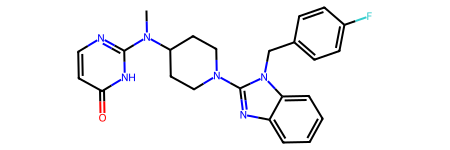

In [105]:
#Define new SMILES string and view
new_smiles = "CC(=O)OC1=CC=CC=C1C(=O)O" # CID 2242 aspirin should be INactive
#new_smiles = "C1=CC=C(C=C1)C(C2=CC=CC=C2)(C3=CC=CC=C3Cl)N4C=CN=C4" # CID = 2812 should be active
#new_smiles = "C1=CC=C(C(=C1)C2=NC(=NO2)C3=CC=NC=C3)Cl" #CID 65758 should be active
#new_smiles = "C1=CC(=CC=C1C2=COC3=CC(=CC(=C3C2=O)O)O)O" #CID 5280961 should be active
new_smiles = "CN(C1CCN(CC1)C2=NC3=CC=CC=C3N2CC4=CC=C(C=C4)F)C5=NC=CC(=O)N5" #CID 65906 should be INactive
#new_smiles = "C1=CNC(=O)NC1=O" #CID 1174 should be INactive
#new_smiles = "CCCCCC1=CC(=C2C=CC(OC2=C1)(C)CCC=C(C)C)O" #CID30219 not in datbase (CBC)
#new_smiles = "C[C@H]1C[C@@H](C(=O)[C@@H](C1)[C@@H](CC2CC(=O)NC(=O)C2)O)C" #CID 6197 should be active
#new_smiles = "CCCCCC1=CC(=C2[C@@H]3C=C(CC[C@H]3C(OC2=C1)(C)C)C)O" #CID16078 in database and should be active (THC)
#new_smiles = "COC1=CC(=CC(=C1OC)OC)CCN" #CID4076 not in database (mescaline)
#new_smiles = "CC1=C(C(CCC1)(C)C)/C=C/C(=C/C=C/C(=C/CO)/C)/C" # vitamin A not in database
mol = Chem.MolFromSmiles(new_smiles)
mol

In [106]:
from rdkit.DataStructs import ConvertToNumpyArray
import numpy as np
fp = MACCSkeys.GenMACCSKeys(mol)
arr = np.zeros((1,), dtype=int) 
ConvertToNumpyArray(fp, arr)
arr_filtered = sel.transform(arr.reshape(1, -1))
prediction = clf_NB.predict(arr_filtered)
print(prediction)

[1]


/home/ebucholtz/miniconda3/envs/CHEM3351/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but VarianceThreshold was fitted with feature names
  warnings.warn(


<div class="alert alert-block alert-warning">
<strong>Testing the model</strong>

Test all the new_smiles in the model and add your own SMILES to test the model. Additional molecules you might want to test are androgens (like androstenedione) as they are key substrates for this enzyme. We also know that hydrogen bond donors and acceptors as well as aromatic features are important for interaction with the active site. Formestane and exmestane are known inhibitors. They may or may not be in the training set. It would be interesting to test them here.

 How well is the Bernoulli Naïve Bayes model doing at your predictions? Do you trust it? If you are not satisfied, what would you do to improve it?

## Saving your model

Now that we have trained a model, we should save it for future use to avoid retraining. This can be achieved using either the `pickle` and `joblib` libraries. While `pickle` is the standard python library, `joblib` is often preferred for models with large NumPy arrays, such as our MACCS Keys, because it is more efficient for handling large data structures.

In [102]:
# How to save the model using joblib

import joblib
model = clf_NB #our Naive Bayes model
filename = 'clf_NB_model.joblib' # give our model a name for the file
joblib.dump(model, filename) # save the model to a file
print(f"Model saved to {filename}")



Model saved to clf_NB_model.joblib


In [103]:
# How to load the model using joblib
import joblib
savedmodel = joblib.load(filename) # load the model from the file
print("Model loaded from file.")


# Use the loaded model to make predictions on the test set
# This assumes that X_test is already defined and preprocessed in the same way as during training
predictions = savedmodel.predict(X_test)
print(predictions)

# Use the loaded model to make predictions on a new SMILES string
# This assumes that the new SMILES string is preprocessed in the same way as during training
new_smiles = "CC(=O)OC1=CC=CC=C1C(=O)O" # CID 2242 aspirin should be INactive
mol = Chem.MolFromSmiles(new_smiles)

from rdkit.DataStructs import ConvertToNumpyArray
import numpy as np
fp = MACCSkeys.GenMACCSKeys(mol)
arr = np.zeros((1,), dtype=int) 
ConvertToNumpyArray(fp, arr)
arr_filtered = sel.transform(arr.reshape(1, -1))
prediction = savedmodel.predict(arr_filtered)
print(prediction)


Model loaded from file.
[0 1 1 0 0 1 1 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 1
 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 1 1 1 0 0 1 1 0 1 1 0 1 1 0 1 0 0 0 0 0
 0 0 0 1 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0
 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 1 0 1 0 0 0 1 0
 0 1 1 1 0 0 0 0 0 1 1 0 0 1 0 1 1 1 1 1 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 0 0
 1 1 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0
 0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 1 1 1
 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1
 1 0 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1 1 1 0 0 1 1 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 1 0 0 0 0 1 0 0 0 1
 0 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 1 1 0 1 0 0 0 0
 0 0 0 1 1 0 1 0 0 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 0 0 0 0 1 1 0 0 1
 1 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1
 

/home/ebucholtz/miniconda3/envs/CHEM3351/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but VarianceThreshold was fitted with feature names
  warnings.warn(


Saving a model as a **pipeline** in scikit-learn ensures that all preprocessing steps and the trained model are bundled together into a single, reusable object. This approach prevents common mistakes that occur when applying a model to new data, such as forgetting to apply feature selection, scaling, or encoding in the same way as during training.

In a pipeline, each step. such as generating MACCS fingerprints, filtering low-variance features with VarianceThreshold, and training a classifier like BernoulliNB, is linked in sequence.

Once the pipeline is trained, it can be saved using joblib.dump() and later reloaded with joblib.load() for consistent predictions in new notebooks or projects. By storing both the data preprocessing and the model in one file, a pipeline guarantees that any new molecule passed through it will undergo the exact same transformations before prediction, ensuring reproducibility and reliability of results in cheminformatics workflows.

In [104]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.naive_bayes import BernoulliNB
import joblib

pipe = Pipeline([
    ("var", VarianceThreshold(threshold=0.0)),
    ("clf", BernoulliNB())
])

pipe.fit(X_MACCS, y)
joblib.dump(pipe, "nb_maccs_pipeline.joblib")

['nb_maccs_pipeline.joblib']

In [ ]:
pipe = joblib.load("nb_maccs_pipeline.joblib")
# build arr from MACCS as above...
X_query = arr.reshape(1, -1)
pred = pipe.predict(X_query)  # no manual masking needed

### 8b Decision Tree

Decision Tree Classification is a machine learning algorithm that predicts whether a molecule is active or inactive by asking a series of yes/no questions based on its features. We will employ this method to look for MACCS Keys. The algorithm builds a tree-like model where each question splits the data to better separate active from inactive compounds. It chooses the questions based on how well they divide the data into pure groups. When a group is pure, it will mostly contain molecules of one class. 

In [ ]:
# set up the DT classification model
clf_DT = DecisionTreeClassifier( random_state=0 )    

In [ ]:
# Train the model by fitting it to the data (using the default values for all parameters)
# we are using the same training data as before
clf_DT.fit( X_train ,y_train )    

In [ ]:
# Apply the model to predict the training compound's activity.
y_true, y_pred = y_train, clf_DT.predict( X_train )    

In [ ]:
# generate confusion matrix
CMat = confusion_matrix( y_true, y_pred )   
print(CMat)    # [[TN, FP], 
               #  [FN, TP]]
# Extracting TN, FP, FN, TP from the confusion matrix               
TN = CMat[0, 0]  # True Negatives
FP = CMat[0, 1]  # False Positives
FN = CMat[1, 0]  # False Negatives
TP = CMat[1, 1]  # True Positives

print("True Negatives (TN):", TN)
print("False Positives (FP):", FP)
print("False Negatives (FN):", FN)
print("True Positives (TP):", TP)

print("Total predictions:", TN + FP + FN + TP)

In [ ]:
acc  = accuracy_score( y_true, y_pred ) #correct predictions/total predictions = (TP+TN)/(TP+TN+FP+FN)
prec = TP / (TP + FP)    # precision = TP / (TP + FP) measures how well model identifies actual positives
sens = TP / (FN + TP)    # sensitivity = TP / (FN + TP) measures how well model identifies actual positives
spec = TN / (TN + FP)    # specificity = TN / (TN + FP)measures how well model identifies actual negatives
bacc = (sens + spec) / 2    #averages sensititivy and specificity
f1_score = 2 * (prec * sens) / (prec + sens)  # F1 score is the harmonic mean of precision and sensitivity

y_score = clf_DT.predict_proba( X_train )[:, 1] #returns proability of each class, [:, 1] extracts the probability of the positive class (label 1) for each sample.
auc = roc_auc_score( y_true, y_score ) #measures how well the model ranks psitive vs negative samples. AUC = 1.0 → perfect model; AUC = 0.5 → random guessing.

print("Training set performance metrics:")
print(f"Accuracy          = {acc:.4f}") # how accurate is the model overall
print(f"Precision         = {prec:.4f}") # How well it identifies actual positives (precision)
print(f"Sensitivity       = {sens:.4f}") # How well it catches positives (sensitivity)
print(f"Specificity       = {spec:.4f}") # How well it avoids false negatives (specificity)
print(f"Balanced Accuracy = {bacc:.4f}") # How balanced its performance is across classes
print(f"F1 Score          = {f1_score:.4f}") # Harmonic mean of precision and sensitivity
print(f"AUC-ROC           = {auc:.4f}")  #How well it ranks predictions (AUC)

<div class="alert alert-block alert-warning">
<strong>Interpreting key metrics from the confusion matrix</strong>

Using the Classification Metrics Interpretation Guide, how well did the decision tree model predict those molecules in the training set?

Let's test the molecules in the test set.

In [ ]:
y_true, y_pred = y_test, clf_DT.predict(X_test)    #-- Apply the model to predict the test set compounds' activity.

In [ ]:
# generate confusion matrix
CMat = confusion_matrix( y_true, y_pred )   
print(CMat)    # [[TN, FP], 
               #  [FN, TP]]
# Extracting TN, FP, FN, TP from the confusion matrix               
TN = CMat[0, 0]  # True Negatives
FP = CMat[0, 1]  # False Positives
FN = CMat[1, 0]  # False Negatives
TP = CMat[1, 1]  # True Positives

print("True Negatives (TN):", TN)
print("False Positives (FP):", FP)
print("False Negatives (FN):", FN)
print("True Positives (TP):", TP)

print("Total predictions:", TN + FP + FN + TP)

In [ ]:
acc  = accuracy_score( y_true, y_pred ) #correct predictions/total predictions = (TP+TN)/(TP+TN+FP+FN)
prec = TP / (TP + FP)    # precision = TP / (TP + FP) measures how well model identifies actual positives
sens = TP / (FN + TP)    # sensitivity = TP / (FN + TP) measures how well model identifies actual positives
spec = TN / (TN + FP)    # specificity = TN / (TN + FP)measures how well model identifies actual negatives
bacc = (sens + spec) / 2    #averages sensititivy and specificity
f1_score = 2 * (prec * sens) / (prec + sens)  # F1 score is the harmonic mean of precision and sensitivity

y_score = clf_DT.predict_proba( X_test )[:, 1] #returns proability of each class, [:, 1] extracts the probability of the positive class (label 1) for each sample.
auc = roc_auc_score( y_true, y_score ) #measures how well the model ranks psitive vs negative samples. AUC = 1.0 → perfect model; AUC = 0.5 → random guessing.

print("Training set performance metrics:")
print(f"Accuracy          = {acc:.4f}") # how accurate is the model overall
print(f"Precision         = {prec:.4f}") # How well it identifies actual positives (precision)
print(f"Sensitivity       = {sens:.4f}") # How well it catches positives (sensitivity)
print(f"Specificity       = {spec:.4f}") # How well it avoids false negatives (specificity)
print(f"Balanced Accuracy = {bacc:.4f}") # How balanced its performance is across classes
print(f"F1 Score          = {f1_score:.4f}") # Harmonic mean of precision and sensitivity
print(f"AUC-ROC           = {auc:.4f}")  #How well it ranks predictions (AUC)

<div class="alert alert-block alert-warning">
<strong>Interpreting key metrics from the confusion matrix</strong>

Using the Classification Metrics Interpretation Guide, how well did the decision tree model predict those molecules in the test set?

Such high performance on the training set, especially for a flexible model like a decision tree,  is often a sign of **overfitting**.

When applied to predict the activity of the **training** compounds, the DT classifier resulted in very high scores (>0.99) for all five performance measures considered here. The model may have memorized the training data, especially if the tree is very deep or was not pruned. This would result in poor generalization to new, unseen data. As we saw in the test set, the model performed poorly, which is why **test set** evaluation is critical.

## 9. Model building through cross-validation

In the above section, the models were developed using the default values for many optional hyperparameters, which cannot be learned by the training algorithm.  For example, when building a **decision tree** model, one should specify how deep the *tree* should be, how many compounds should be allowed in a *single leaf*, what is the minimum number of compounds in a *single leaf*, etc.

Grid search and cross-validation are techniques used together to find the best settings for a machine learning model and ensure it generalizes well to new data. Decision trees have additional settings called hyperparameters. These are values that control how the model learns (e.g., the maximum depth of a decision tree, or how many samples are needed to split a node). These are not learned from the data but must be chosen manually. **Grid search** is a method that systematically tries different combinations of hyperparameter values to see which perform best.

To avoid relying on just one train/test split, cross-validation divides the training data into several folds (often 5 or 10), training the model on some folds and validating on the rest, rotating through all folds. This gives a more reliable estimate of model performance. When used together, grid search with cross-validation helps find the best hyperparameter combination while reducing the risk of overfitting.

The cells below demonstrate how to perform hyperparameter optimization through 10-fold cross-validation.  In this example, five values for each of three hyperparameters used in the decision tree are considered (max_depth, min_samples_split, and min_samples_leaf), resulting in a total of 125 combination of the parameter values (= 5 x 5 x 5).  For each combination, 10 models are generated (through 10-fold cross validation) and the average performance will be tracked.  The goal is to find the parameter value combination that results in the highest average performance score (e.g., 'roc_auc') from the 10-fold cross validation.

In [ ]:
#GridSearchCV stands for Grid Search with Cross-Validation.
from sklearn.model_selection import GridSearchCV 

In [ ]:
#For each model configuration, calculate both ROC-AUC and balanced accuracy
scores = [ 'roc_auc', 'balanced_accuracy' ] 

In [ ]:
ncvs = 10  #sets number of cross-validation folds to 10, the training set is split into 10 parts. In each iteration, the model is trained on 9 parts and validated on the remaining 1.
                        # np.linspace() to create evenly spaced integer values in the given ranges.
max_depth_range         = np.linspace( 3, 7, num=5, dtype='int32' )  #Maximum depth of the tree (e.g., [3, 4, 5, 6, 7])
min_samples_split_range = np.linspace( 3, 7, num=5, dtype='int32' )  # Minimum number of samples needed to split a node
min_samples_leaf_range  = np.linspace( 2, 6, num=5, dtype='int32' )  #Minimum number of samples needed to be a leaf node

param_grid = dict( max_depth=max_depth_range,                     #This is a dictionary mapping parameter names to lists of values to try.
                   min_samples_split=min_samples_split_range,     #GridSearchCV will try every combination of the 5 × 5 × 5 = 125 settings.
                   min_samples_leaf=min_samples_leaf_range )

clf_DT_CV = GridSearchCV( DecisionTreeClassifier( random_state=0 ),     #creates base model to optimize on AUC and balanced accuracy
                    param_grid=param_grid, cv=ncvs, scoring=scores, refit='roc_auc',
                    return_train_score = True)   

In [ ]:
# This cell will take some time to run. In testing it took just over a 1 minute, but that will 
# depend on user hardware.
clf_DT_CV.fit( X_train, y_train )   #triggers the full grid search with cross-validation
print("Best parameter set", clf_DT_CV.best_params_) #prints the best-performing hyperparameters. Tells us which combo gives highest CV and used for future predict.

If necessary, it is possible to look into the performance data for each parameter value combination (stored in **clf.cv_results_**), as shown in the following cell.

In [ ]:
means_1a = clf_DT_CV.cv_results_['mean_train_roc_auc'] #Gives mean and STDV for AUC for training data 
stds_1a  = clf_DT_CV.cv_results_['std_train_roc_auc']

means_1b = clf_DT_CV.cv_results_['mean_test_roc_auc'] #Gives mean and STDV for AUC for test data 
stds_1b  = clf_DT_CV.cv_results_['std_test_roc_auc']

means_2a = clf_DT_CV.cv_results_['mean_train_balanced_accuracy'] #Gives mean and STDV for Balanced accuracy for training data 
stds_2a  = clf_DT_CV.cv_results_['std_train_balanced_accuracy']

means_2b = clf_DT_CV.cv_results_['mean_test_balanced_accuracy']  #Gives mean and STDV for Balanced accuracy  for test data 
stds_2b  = clf_DT_CV.cv_results_['std_test_balanced_accuracy']

iterobjs = zip( means_1a, stds_1a, means_1b, stds_1b,           #Combines all the relevant stats with their corresponding parameter combinations into one iterable.
                means_2a, stds_2a, means_2b, stds_2b, clf_DT_CV.cv_results_['params'] )

for m1a, s1a, m1b, s1b, m2a, s2a, m2b, s2b, params in iterobjs :  #for each grid point gives all the data

    print( "Grid %r : %0.4f %0.04f %0.4f %0.04f %0.4f %0.04f %0.4f %0.04f"
           % ( params, m1a, s1a, m1b, s1b, m2a, s2a, m2b, s2b))  

Uncomment the following cell to look into additional performance data stored in cv_result_.

In [ ]:
#print(clf_DT_CV.cv_results_)

It is important to understand that each model built through 10-fold cross-validation during hyperparameter optimization uses only 90% of the compounds in the training set and the remaining 10% is used for testing that model.  After all parameter value combinations are evaluated, the best parameter values are selected and used to rebuild a model from **all** compounds in the training set.  **GridSearchCV()** takes care of this last step automatically.  Therefore, there is no need to take an extra step to build a model using **cls.fit()** after hyperparameter optimization.

In [ ]:
# Apply the model to predict the training compound's activity.
y_true, y_pred = y_train, clf_DT_CV.predict( X_train )    

In [ ]:
# generate confusion matrix
CMat = confusion_matrix( y_true, y_pred )   
print(CMat)    # [[TN, FP], 
               #  [FN, TP]]
# Extracting TN, FP, FN, TP from the confusion matrix               
TN = CMat[0, 0]  # True Negatives
FP = CMat[0, 1]  # False Positives
FN = CMat[1, 0]  # False Negatives
TP = CMat[1, 1]  # True Positives

print("True Negatives (TN):", TN)
print("False Positives (FP):", FP)
print("False Negatives (FN):", FN)
print("True Positives (TP):", TP)

print("Total predictions:", TN + FP + FN + TP)

In [ ]:
acc  = accuracy_score( y_true, y_pred ) #correct predictions/total predictions = (TP+TN)/(TP+TN+FP+FN)
prec = TP / (TP + FP)    # precision = TP / (TP + FP) measures how well model identifies actual positives
sens = TP / (FN + TP)    # sensitivity = TP / (FN + TP) measures how well model identifies actual positives
spec = TN / (TN + FP)    # specificity = TN / (TN + FP)measures how well model identifies actual negatives
bacc = (sens + spec) / 2    #averages sensititivy and specificity
f1_score = 2 * (prec * sens) / (prec + sens)  # F1 score is the harmonic mean of precision and sensitivity

y_score = clf_DT_CV.predict_proba( X_train )[:, 1] #returns proability of each class, [:, 1] extracts the probability of the positive class (label 1) for each sample.
auc = roc_auc_score( y_true, y_score ) #measures how well the model ranks psitive vs negative samples. AUC = 1.0 → perfect model; AUC = 0.5 → random guessing.

print("Training set performance metrics:")
print(f"Accuracy          = {acc:.4f}") # how accurate is the model overall
print(f"Precision         = {prec:.4f}") # How well it identifies actual positives (precision)
print(f"Sensitivity       = {sens:.4f}") # How well it catches positives (sensitivity)
print(f"Specificity       = {spec:.4f}") # How well it avoids false negatives (specificity)
print(f"Balanced Accuracy = {bacc:.4f}") # How balanced its performance is across classes
print(f"F1 Score          = {f1_score:.4f}") # Harmonic mean of precision and sensitivity
print(f"AUC-ROC           = {auc:.4f}")  #How well it ranks predictions (AUC)

<div class="alert alert-block alert-warning">
<strong>Interpreting key metrics from the confusion matrix on training set</strong>

Compare these performance data with those from section 8b. (for the training set only).  

In [ ]:
#-- Apply the model to predict the test set compounds' activity.
y_true, y_pred = y_test, clf_DT_CV.predict(X_test)    

In [ ]:
# generate confusion matrix
CMat = confusion_matrix( y_true, y_pred )   
print(CMat)    # [[TN, FP], 
               #  [FN, TP]]
# Extracting TN, FP, FN, TP from the confusion matrix               
TN = CMat[0, 0]  # True Negatives
FP = CMat[0, 1]  # False Positives
FN = CMat[1, 0]  # False Negatives
TP = CMat[1, 1]  # True Positives

print("True Negatives (TN):", TN)
print("False Positives (FP):", FP)
print("False Negatives (FN):", FN)
print("True Positives (TP):", TP)

print("Total predictions:", TN + FP + FN + TP)

In [ ]:
acc  = accuracy_score( y_true, y_pred ) #correct predictions/total predictions = (TP+TN)/(TP+TN+FP+FN)
prec = TP / (TP + FP)    # precision = TP / (TP + FP) measures how well model identifies actual positives
sens = TP / (FN + TP)    # sensitivity = TP / (FN + TP) measures how well model identifies actual positives
spec = TN / (TN + FP)    # specificity = TN / (TN + FP)measures how well model identifies actual negatives
bacc = (sens + spec) / 2    #averages sensititivy and specificity
f1_score = 2 * (prec * sens) / (prec + sens)  # F1 score is the harmonic mean of precision and sensitivity

y_score = clf_DT_CV.predict_proba( X_test )[:, 1] #returns proability of each class, [:, 1] extracts the probability of the positive class (label 1) for each sample.
auc = roc_auc_score( y_true, y_score ) #measures how well the model ranks psitive vs negative samples. AUC = 1.0 → perfect model; AUC = 0.5 → random guessing.

print("Training set performance metrics:")
print(f"Accuracy          = {acc:.4f}") # how accurate is the model overall
print(f"Precision         = {prec:.4f}") # How well it identifies actual positives (precision)
print(f"Sensitivity       = {sens:.4f}") # How well it catches positives (sensitivity)
print(f"Specificity       = {spec:.4f}") # How well it avoids false negatives (specificity)
print(f"Balanced Accuracy = {bacc:.4f}") # How balanced its performance is across classes
print(f"F1 Score          = {f1_score:.4f}") # Harmonic mean of precision and sensitivity
print(f"AUC-ROC           = {auc:.4f}")  #How well it ranks predictions (AUC)

<div class="alert alert-block alert-warning">
<strong>Interpreting key metrics from the confusion matrix on test set</strong>

Compare these performance data with those from section 8b. (for the test set only).  


Let's use the new cross-validated decision tree model to predict the same molecules we had used before.

In [ ]:
#Define new SMILES string
new_smiles = "CC(=O)OC1=CC=CC=C1C(=O)O" # CID 2242 aspirin should be INactive
#new_smiles = "C1=CC=C(C=C1)C(C2=CC=CC=C2)(C3=CC=CC=C3Cl)N4C=CN=C4" # CID = 2812 should be active
#new_smiles = "C1=CC=C(C(=C1)C2=NC(=NO2)C3=CC=NC=C3)Cl" #CID 65758 should be active
#new_smiles = "C1=CC(=CC=C1C2=COC3=CC(=CC(=C3C2=O)O)O)O" #CID 5280961 should be active
#new_smiles = "CN(C1CCN(CC1)C2=NC3=CC=CC=C3N2CC4=CC=C(C=C4)F)C5=NC=CC(=O)N5" #CID 65906 should be INactive
#new_smiles = "C1=CNC(=O)NC1=O" #CID 1174 should be INactive
#new_smiles = "CCCCCC1=CC(=C2C=CC(OC2=C1)(C)CCC=C(C)C)O" #CID30219 not in datbase (CBC)
#new_smiles = "C[C@H]1C[C@@H](C(=O)[C@@H](C1)[C@@H](CC2CC(=O)NC(=O)C2)O)C" #CID 6197 should be active
#new_smiles = "CCCCCC1=CC(=C2[C@@H]3C=C(CC[C@H]3C(OC2=C1)(C)C)C)O" #CID16078 in database and should be active (THC)
#new_smiles = "COC1=CC(=CC(=C1OC)OC)CCN" #CID4076 not in database (mescaline)
#new_smiles = "CC1=C(C(CCC1)(C)C)/C=C/C(=C/C=C/C(=C/CO)/C)/C" # vitamin A not in database
mol = Chem.MolFromSmiles(new_smiles)
mol

In [ ]:
from rdkit.DataStructs import ConvertToNumpyArray
import numpy as np
fp = MACCSkeys.GenMACCSKeys(mol)
arr = np.zeros((1,), dtype=int) 
ConvertToNumpyArray(fp, arr)
arr_filtered = sel.transform(arr.reshape(1, -1))
prediction = clf_DT_CV.predict(arr_filtered)
print(prediction)

<div class="alert alert-block alert-warning">
<strong>Comparing Naive Bayes and Cross Validated Decision Tree Models</strong>

How do these to models compare in their accuracy and AUC-ROC? Is one particularly better than the other in the test set data? 



<div class="alert alert-block alert-success">

# <center>Homework</center>

There are three parts to this homework assignment:

1) Generate a new model with Random Forest and ECFP4 equivalent descriptors.
2) Compare models
3) Journal article review

<div class="alert alert-block alert-success">

## Part 1: Random Forest with ECFP4 descriptors
In this assignment, we will build predictive models using the same aromatase data. However, you will use a random forest classifier and ECFP4 as descriptors.

**step 1** Show the following information to make sure that the activity data in the **df_activity** data frame is still available.

- The first five lines of **df_activity**

In [ ]:
df_activity.head(5)

- The counts of active/inactive compounds in **df_activity**

In [ ]:
df_activity.groupby('activity').count()

**Step 2** Show the following information to make sure the structure data is still available.

- The first five lines of **df_smiles**

In [ ]:
df_smiles.head(5)

- the number of rows of **df_smiles**

In [ ]:
len(df_smiles)

**Step 3** Generate the (ECFP-equivalent) circular fingerprints from the SMILES strings.
- Use RDKit to generate 1024-bit-long circular fingerprints.
- Set the radius of the circular fingerprint to 2.
- Store the fingerprints in a data_frame called **df_fps2** (along with the CIDs).
- Print the dimension of **df_fps2**.
- Show the first five lines of **df_fps2**.

In [ ]:
# write your code here


**Step 4** Merge the **df_activity** and **df_fps2** data frames into a data frame called **df_data2**
- Join the two data frames using the CID column as keys.
- Remove the rows that have any NULL values (i.e., compounds for which the fingerprints couldn't be generated).
- Print the dimension of **df_data2**.
- Show the first five lines of **df_data2**.

In [ ]:
# write your code here


**Step 5** Prepare input and output data for model building
- Load the fingerprint data into 2-D array (X) and the activity data into 1-D array (y).
- Show the dimension of X and y.

In [ ]:
# write your code here


- Remove zero-variance features from X (if any).

In [ ]:
# write your code here


- Split the data set into training and test sets (90% vs 10%) (using random_state=3100).
- Print the dimension of X and y for the training and test sets.

In [ ]:
# Write your code in this cell.



- Balance the training data set through downsampling.
- Show the number of inactive/active compounds in the downsampled training set.

In [ ]:
# write your code here


**Step 6** Building a Random Forest model using the balanced training data set.
- First read the followng documents about random forest (https://scikit-learn.org/stable/modules/ensemble.html#forest and https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier). 
- Use 10-fold cross validation to select the best value for the "n_estimators" parameter that maximizes the **balanced accuracy**.  Test 40 values from 5 to 200 with an increment of 5 (e.g., 5, 10, 15, 20, ..., 190, 195, 200).
- For parameters 'max_depth', 'min_samples_leaf', and 'min_samples_split', use the best values found in Section 9.
- For other parameters, use the default values.
- For each parameter value, print the mean balanced accuracies (for both training and test from cross validation).

In [ ]:
# write your code here



**Step 7** Apply the developed RF model to predict the activity of the **training** set compounds.

- Report the confusion matrix.
- Report the accuracy, balanced accuracy, sensitivity, specificity, and auc-roc.

In [ ]:
# write your code here

**Step 8** Apply the developed RF model to predict the activity of the **test** set compounds.

- Report the accuracy, balanced accurayc, sensitivity, specificity, and auc-roc.

In [ ]:
# write your code here



**Step 9** Test this model on your previous selected molecules

In [ ]:
#Define new SMILES string
new_smiles = "CC(=O)OC1=CC=CC=C1C(=O)O" # CID 2242 aspirin should be INactive
#new_smiles = "C1=CC=C(C=C1)C(C2=CC=CC=C2)(C3=CC=CC=C3Cl)N4C=CN=C4" # CID = 2812 should be active
#new_smiles = "C1=CC=C(C(=C1)C2=NC(=NO2)C3=CC=NC=C3)Cl" #CID 65758 should be active
#new_smiles = "C1=CC(=CC=C1C2=COC3=CC(=CC(=C3C2=O)O)O)O" #CID 5280961 should be active
#new_smiles = "CN(C1CCN(CC1)C2=NC3=CC=CC=C3N2CC4=CC=C(C=C4)F)C5=NC=CC(=O)N5" #CID 65906 should be INactive
#new_smiles = "C1=CNC(=O)NC1=O" #CID 1174 should be INactive
#new_smiles = "CCCCCC1=CC(=C2C=CC(OC2=C1)(C)CCC=C(C)C)O" #CID30219 not in datbase (CBC)
#new_smiles = "C[C@H]1C[C@@H](C(=O)[C@@H](C1)[C@@H](CC2CC(=O)NC(=O)C2)O)C" #CID 6197 should be active
#new_smiles = "CCCCCC1=CC(=C2[C@@H]3C=C(CC[C@H]3C(OC2=C1)(C)C)C)O" #CID16078 in database and should be active (THC)
#new_smiles = "COC1=CC(=CC(=C1OC)OC)CCN" #CID4076 not in database (mescaline)
#new_smiles = "CC1=C(C(CCC1)(C)C)/C=C/C(=C/C=C/C(=C/CO)/C)/C" # vitamin A not in database
mol = Chem.MolFromSmiles(new_smiles)
mol

In [ ]:
# write your code here


<div class="alert alert-block alert-success">

## Part 2: Model Comparison and Prediction Evaluation 

You have now trained and evaluated three different classification models on aromatase inhibitor data:
- Naive Bayes and Decision Tree using MACCS Keys
- Random Forest using ECFP4 fingerprints

Instructions:
1. Create a summary table in Excel that includes the following for each model: (I will provide the Excel template)
-  Overall performance metrics (e.g., accuracy, balanced accuracy, ROC-AUC, F1-score)
- Any notes on overfitting or class imbalance (e.g., large train/test gaps)
- Strengths or weaknesses you observed based on the model type or feature set

2. Evaluate predictions for individual molecules:
- Include a row for each test set molecule (or selected examples).
- For each molecule, note the predicted activity (active/inactive) from each model.
- Highlight any molecules where different models gave different predictions.

3. Reflection:
- Did any of your molecules outside the original dataset (e.g., ones you added) receive different predictions depending on the model?
- Which model do you trust most for these borderline cases, and why?

<div class="alert alert-block alert-success">

## Part 3 
Read the following two papers (You may need to request them via interlibrary loan.) 
- Paper 1: *Chem. Res. Toxicol.* (https://doi.org/10.1021/acs.chemrestox.7b00037)
- Paper 2: *Environmental Science & Technology* (https://doi.org/10.1021/acs.est.0c05771)

Answer the following questions (in no more than five sentences for each question).

- What different approaches did the *Chem. Res. Toxicol.* paper take to develop prediction models (how do they compare to those used in this notebook)?
- How different are the models reported in the *Chem. Res. Toxicol.* paper from those constructed in the *Environmental Science & Technology* paper (in terms of the performance measures)? 
- What would you do to develop models with improved performance?
- How could you use the molecular similarity notebook you developed in this course to find and test other likely active molecules at P450 19A1?